# Part I: Profiling expression STRs across 17 human tissues

This notebook contains info for:

#### Figures
* **Figure 1D** causal examples

#### Supplementary Tables:
* **Supplementary Table LITERATURE**

In [1]:
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-calling"
FIGPREFIX = "SuppFig"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = COLORS.keys()

############ Load linear regression data #############
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "%s_LinearRegression.tab"%t), sep="\t", usecols=[0,1,3,8,11])
    data[t]["str.start"] = (data[t]["str.start"]).apply(int)

Populating the interactive namespace from numpy and matplotlib


/home/mgymrek/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: Runtime

In [2]:
# Get best tissue for a given eSTR
PTHRESH = 0.01 # print all
def GetBestTissue(chrom, start, gene, data):
    """
    Return tissue, pval, beta
    """
    best_tissue = None
    best_p = 1
    best_beta = None
    for t in data:
        x = data[t]
        x = x[(x["chrom"]==chrom) & (x["str.start"]==start) & (x["gene"]==gene)]
        if x.shape[0] == 0: continue
        if x["p.wald"].values[0] <= best_p:
            best_tissue = t
            best_p = x["p.wald"].values[0]
            best_beta = x["beta"].values[0]
        if  x["p.wald"].values[0] < PTHRESH:
            print("%s %s %s"%(t, x["p.wald"].values[0], x["beta"].values[0]))
    return best_tissue, best_p, best_beta
    
def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotESTR(gene, tissue, chrom, start, end, COLORS, fname=None):
    ExtractData(gene, chrom, start, tissue)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]

    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="black", marker="o")
    ax.set_xlabel("Allele length (bp)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item)+(end-start+2)*2 for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)
        
def ExtractRawData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Clean_expression.tsv"%tissue
    cmd = """cat %s | grep \"%s\|GTEX\" | sed 's/\"//g' | sed 's/^GTEX/gene\\tGTEX/' | datamash transpose | grep -v ENSG | sed 's/\\t/,/g'> expr.tab  """%(expr,gene)
    #print(cmd)
    #colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    #cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotRawESTR(gene, tissue, chrom, start, end, COLORS, fname=None, maxy=None):
    ExtractRawData(gene, chrom, start, tissue)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    expr["sample"] = expr["sample"].apply(lambda x: x.replace(".","-"))
    data = pd.merge(strgt, expr)
    
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]

    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="black", marker="o")
    if maxy is not None: ax.set_ylim(bottom=0, top=maxy)
    ax.set_xlabel("Allele length (bp)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item)+(end-start+2)*2 for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)


# CSTB

https://www.ncbi.nlm.nih.gov/pubmed/9126745
repeat involved in EPM1 (progressive myoclonus epilepsy MIM 254800)
mutant alleles contain 60+ copies. normal alleles 2-3 copies

https://www.ncbi.nlm.nih.gov/pubmed/22573514
CSTB causal eQTL. Figure 1B. more repeats = more expression

https://www.ncbi.nlm.nih.gov/pubmed/10441345
propose here the mechanism is altered spacing

Skin-NotSunExposed 6.339980281606235e-07 0.3419327648502498
Esophagus-Muscularis 2.7563910296998874e-09 0.4020328183061333
Thyroid 4.1322697025400756e-16 0.4801373588533952
Adipose-Visceral 2.4937880117961275e-06 0.33822105996552443
Cells-Transformedfibroblasts 1.4904429779250703e-18 0.5521154466758411
Muscle-Skeletal 1.286148195159528e-21 0.4904589924356517
Adipose-Subcutaneous 0.0001891850722444315 0.2290882993859059
Skin-SunExposed 1.8756893481002583e-14 0.4296000313279473
WholeBlood 2.1014922735574548e-14 0.4070895467591639
Artery-Tibial 2.2954051577385685e-15 0.4581644098671728
Artery-Aorta 1.9626488165263646e-05 0.30828105920092885
Heart-LeftVentricle 1.630030072311266e-11 0.4614220913424358
Nerve-Tibial 7.331667966724233e-14 0.4451180552487229


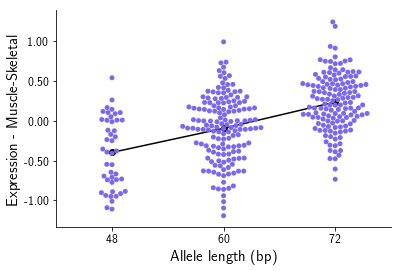

In [3]:
chrom = "chr21"
start = 45196326
end = 45196360
gene = "ENSG00000160213.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CSTB.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

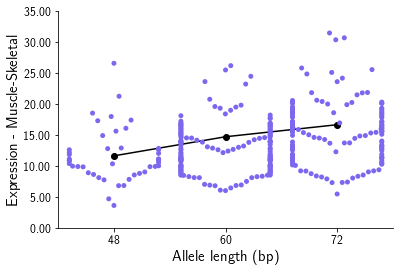

In [4]:
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=35)

# PIG3 (TP53I3)

https://www.nature.com/articles/ng836
number of repeats positively correlated with expression, only in the presence of p53 (Figure 5b)

Thyroid 0.0006043215012692471 0.2216459057733232
Esophagus-Mucosa 0.008148316941980148 0.1763826888243387
Muscle-Skeletal 0.006844134473106718 0.15480586780044353


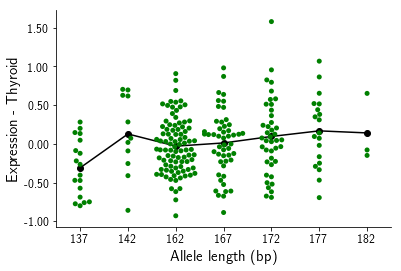

In [5]:
chrom = "chr2"
start = 24307211
end = 24307290
gene = "ENSG00000115129.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PIG3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# MMP9

https://www.ncbi.nlm.nih.gov/pubmed/10428474
polyCA, esophageal carcinoma cell lines
longer repeat = more expression
Figure 3
range tested 0-21 repeats
most Japanese had 20, 21, or 22 repeats

Skin-SunExposed 0.003908333059473693 0.18187989470752275


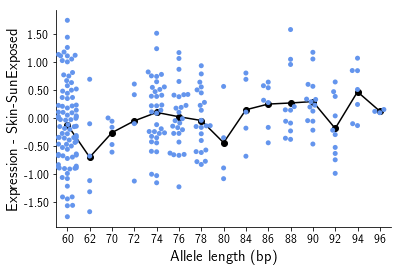

In [6]:
chrom = "chr20"
start = 44637412
end = 44637458
gene = "ENSG00000100985.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MMP9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# EGFR

http://www.jbc.org/content/274/19/13176.long
Figure 4A
16-21 in vivo nonlinear (16 and 20 highest; various cell lines have different numbers)
16-21 in vitro show decreasing trend with expression

Esophagus-Mucosa 0.0017561588027997658 0.21266338120795727
Muscle-Skeletal 0.006974538202550474 0.15839261663021156
Heart-LeftVentricle 0.007359973711983423 -0.20856936945691976


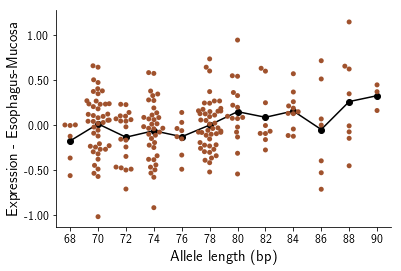

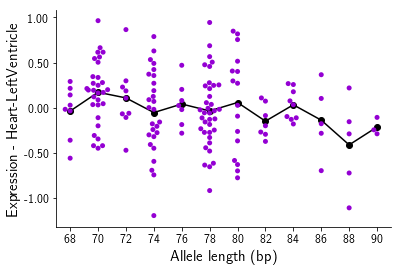

In [7]:
chrom="chr7"
start = 55088253
end = 55088286
gene = "ENSG00000146648.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EGFR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)
PlotESTR(gene, "Heart-LeftVentricle", chrom, start, end, COLORS)

# IFNG

https://www.ncbi.nlm.nih.gov/pubmed/15900487

CA12 and CA15 with decreased and increased expression

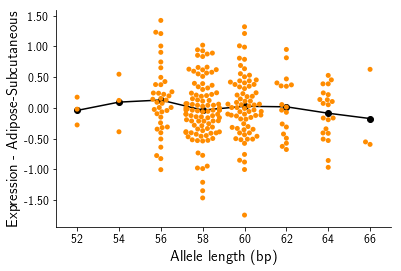

In [8]:
chrom="chr12"
start = 68552495
end = 68552523
gene = "ENSG00000111537.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IFNG.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# UGT1A1
https://www.ncbi.nlm.nih.gov/pubmed/7565971
human hepatoma
longer repeat = reduced expression

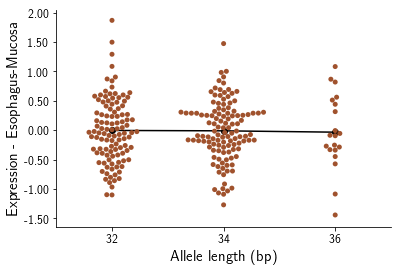

In [9]:
chrom="chr2"
start = 234668880
end = 234668894
gene = "ENSG00000241635.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_Gilbert.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# NOP56

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3135815/
expansion causes SCA36

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5504081/
reduced expression in ipscs of patients (bit expansions)

Skin-NotSunExposed 0.003983216894907949 0.20176436491436384
Thyroid 2.4089756567925805e-08 0.3399550374134861
Muscle-Skeletal 7.763973061996127e-12 0.3639638161260791
Adipose-Subcutaneous 0.0010882684400698 0.2003387759679452
Skin-SunExposed 5.980036839593017e-05 0.2342239733210593
Artery-Tibial 9.530137450101992e-05 0.2369619492780936


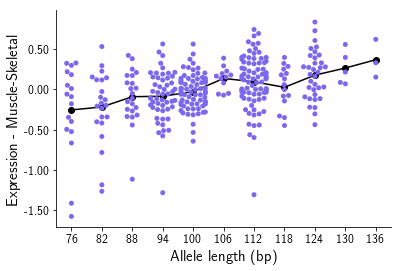

In [10]:
chrom="chr20"
start=2633379
end = 2633421
gene = "ENSG00000101361.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NOP56.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VLDLR

WholeBlood 8.626591585226099e-14 -0.3958859573307789


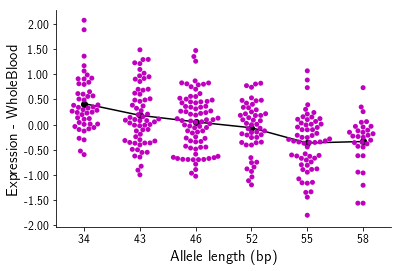

In [11]:
gene = "ENSG00000147852.11"
chrom = "chr9"
start = 2622147
end = 2622171

best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VLDLR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# Jacobsen Syndrome

Cells-Transformedfibroblasts 0.0039303911901327464 -0.1968094713500796


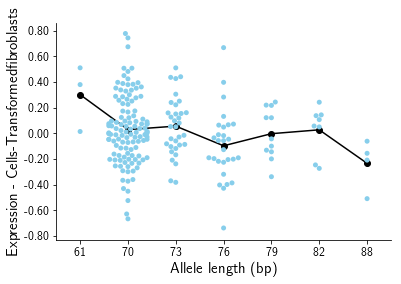

In [12]:
gene = "ENSG00000110395.4"
chrom = "chr11"
start = 119077000
end = 119077033
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CBL.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# ALOX5


Esophagus-Mucosa 4.347912095386305e-07 0.31737116597155063
Brain-Cerebellum 0.00270767041900817 0.28984312234623305
Skin-SunExposed 0.0009001337755839648 -0.1939411613489228


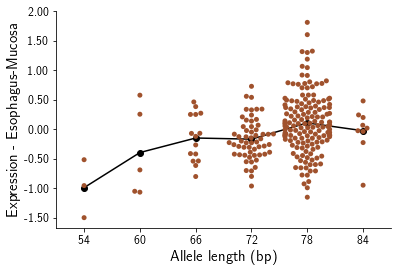

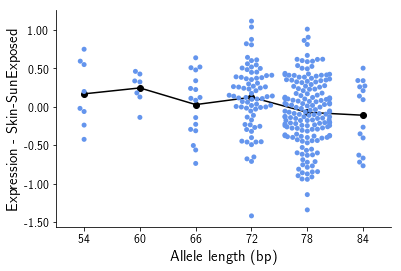

In [13]:
gene = "ENSG00000012779.6"
chrom = "chr10"
start = 45869548
end = 45869585
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ALOX5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotESTR(gene, "Skin-SunExposed", chrom, start, end, COLORS)

# Below are additional examples where expression is not directly tested

# SCNA
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6054541/

repeat length pos relationship with expression
increases binding of nearby TF sites
don't directly test expression

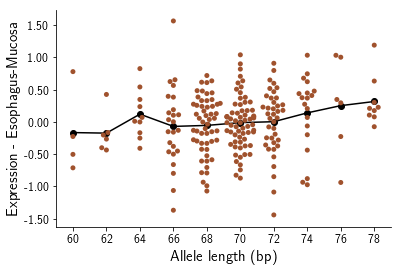

In [14]:
chrom = "chr4"
start = 90636808
end = 90636841
gene = "ENSG00000145335.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SNCA.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS)

# MED19
SCZ GWAS

Skin-NotSunExposed 3.105393422347143e-07 0.3557436264552488
Esophagus-Muscularis 7.660486142644615e-06 0.3097394722752356
Thyroid 3.56528538544888e-06 0.289474257550456
Lung 2.317680069611306e-05 0.2662823032204029
Esophagus-Mucosa 0.0009307086562075193 0.21064297957710576
Brain-Cerebellum 0.001094820593753201 0.3218102727074496
Adipose-Visceral 3.3148010278500404e-06 0.3368927107214041
Cells-Transformedfibroblasts 0.0031928696792304346 0.2011447570096183
Muscle-Skeletal 3.076008055024236e-06 0.2570274444414629
Adipose-Subcutaneous 1.2963494023108917e-12 0.4274209626958312
Skin-SunExposed 2.222394868570618e-08 0.3243412364155367
WholeBlood 6.7522373268889225e-06 0.25095034233973673
Artery-Tibial 4.24800374243584e-06 0.2808033233289799
Nerve-Tibial 0.006461190967527226 0.17391090281358682


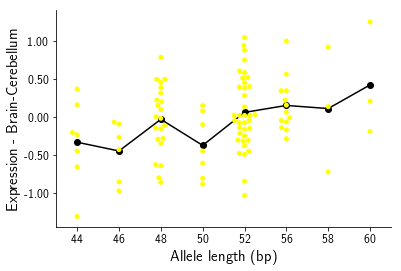

In [15]:
chrom = "chr11"
start = 57523883
end = 57523905
gene = "ENSG00000156603.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
best_tissue = "Brain-Cerebellum"
#if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MED19.pdf")
#else: fname = None
fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

WholeBlood 0.0033644041297225245 0.16500271034442246


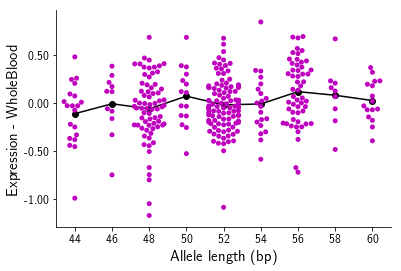

In [16]:
# CTNND1
chrom = "chr11"
start = 57523883
end = 57523905
gene = "ENSG00000198561.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CTNND1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# APH1A
asd gwas

Cells-Transformedfibroblasts 0.0006438921284489278 0.2273044301068341


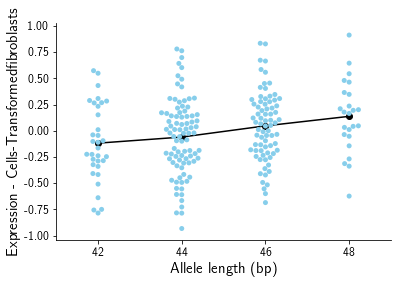

In [17]:
chrom = "chr1"
start = 150314982
end = 150315002
gene = "ENSG00000117362.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_APH1A.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CTNNAL1
SCZ

Skin-NotSunExposed 1.9027582638894875e-08 0.3826830819222248
Esophagus-Muscularis 2.5748588799007324e-06 0.3193780561698013
Adipose-Visceral 0.0014720193577126956 0.2303451134950224
Cells-Transformedfibroblasts 7.358800178348387e-05 0.2646113776994448
Muscle-Skeletal 2.869803274614037e-07 0.2755512900292073
Adipose-Subcutaneous 4.1530073587584525e-06 0.2790078836863977
Skin-SunExposed 4.725819509292028e-06 0.2628752751338485
Artery-Tibial 2.17428046202e-10 0.3759403678100949
Heart-LeftVentricle 0.002947739241851709 0.21185073700072168
Nerve-Tibial 5.747129307451379e-24 0.5735482666210903


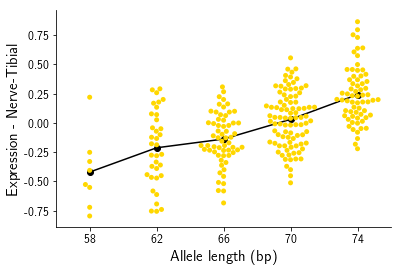

In [18]:
chrom = "chr9"
start = 111783775
end = 111783810
gene = "ENSG00000119326.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CTNNAL1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ATHL1
multiple gwas hits

Skin-NotSunExposed 1.5555424595721646e-13 0.5022100623258655
Esophagus-Muscularis 1.4333476065545024e-18 0.5704144310164405
Thyroid 1.484952132847115e-12 0.4319031988281054
Lung 2.0880797347754893e-11 0.4157705525694744
Esophagus-Mucosa 2.3938299208472997e-12 0.4331028891611895
Brain-Cerebellum 8.379104896879828e-05 0.3848591971605152
Adipose-Visceral 2.047127906376716e-05 0.3142549619610196
Cells-Transformedfibroblasts 2.4098787275960903e-10 0.4173818988225056
Muscle-Skeletal 5.0513096348832675e-20 0.4847069388880421
Adipose-Subcutaneous 3.2524686280616875e-22 0.5638520685159741
Skin-SunExposed 4.115412584916311e-20 0.5143799846475999
WholeBlood 1.553262161119689e-05 0.24271702244845594
Artery-Tibial 1.5680091369527615e-19 0.5266964967794068
Brain-Caudate 5.8518269987856424e-05 0.3925440390713856
Artery-Aorta 6.539920747305734e-11 0.4656526310391155
Heart-LeftVentricle 3.9098688118819607e-14 0.5261591011226466
Nerve-Tibial 4.887620833259244e-18 0.5192112657096155


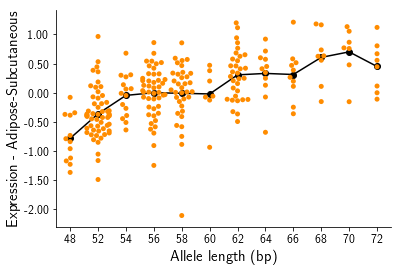

In [19]:
chrom = "chr11"
start = 297578
end = 297600
gene = "ENSG00000142102.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ATHL1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RPUSD3
skin pigmentation gwas


Esophagus-Muscularis 8.915170228543072e-06 -0.30048412682675746
Thyroid 1.4347060700437005e-05 -0.26500063115376243
Lung 8.044625431657362e-09 -0.34938706256012825
Esophagus-Mucosa 1.7448787281806592e-08 -0.3457189602145574
Brain-Cerebellum 0.0004904474701679773 -0.33131755181735834
Adipose-Visceral 0.0001285981762391599 -0.27286287983206925
Cells-Transformedfibroblasts 2.9864352523997397e-07 -0.3357787179245313
Muscle-Skeletal 2.06859269632349e-06 -0.25411868213369265
Adipose-Subcutaneous 1.3957174530372535e-06 -0.2897770493615587
Skin-SunExposed 0.00021153922611013955 -0.2144638212685774
WholeBlood 0.0032323060428837533 -0.16140535656138394
Artery-Tibial 9.746996429052775e-10 -0.3598508440668122
Brain-Caudate 0.00017088482940972493 -0.3555817075541263
Nerve-Tibial 8.547970683761708e-05 -0.2402867472097527


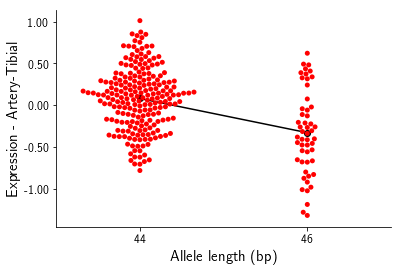

In [20]:
chrom = "chr3"
start = 9883164
end = 9883184
gene = "ENSG00000156990.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RPUSD3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VWA7
   BLOOD PROTEIN GWAS

Muscle-Skeletal 7.260509115042453e-10 -0.3587176770253328
Artery-Tibial 0.00015502554922906982 -0.25012415931831383


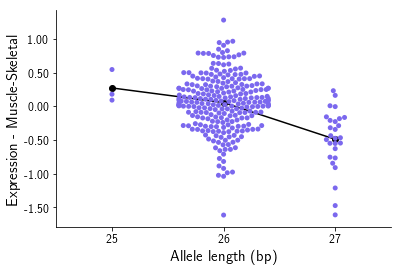

In [21]:
chrom = "chr6"
start = 31699087
end = 31699098
gene = "ENSG00000204396.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VWA7.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# DHRS4
bipolar

Esophagus-Muscularis 0.0006407098681956376 -0.2336967900896481
Muscle-Skeletal 6.748341141187632e-05 -0.21595582152876489
Adipose-Subcutaneous 7.399069004748159e-05 -0.24279300986665225
Skin-SunExposed 2.0934958592133376e-09 0.3448067966041581
Artery-Tibial 1.3071112042472028e-08 -0.33854850605146203
Artery-Aorta 0.0019985588885838733 -0.22520256522846305
Nerve-Tibial 0.00013854732538924044 -0.23686438623556866


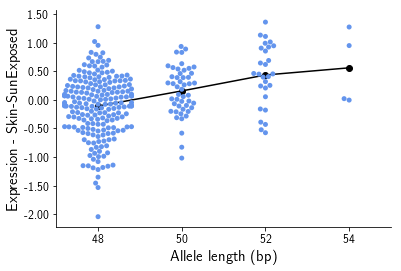

In [22]:
chrom = "chr14"
start = 24392239
end = 24392263
gene = "ENSG00000157326.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DHRS4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IFT74
scz gwas

Skin-NotSunExposed 1.3510760382237762e-09 -0.4425935374592507
Esophagus-Muscularis 0.0002123730061243508 -0.2712493910737458
Thyroid 9.697865745119624e-11 -0.4167723905954094
Lung 4.748902379152423e-08 -0.36024038915338746
Brain-Cerebellum 0.0024011193606927857 -0.3214102747258223
Adipose-Visceral 0.0004778880707988044 -0.26893561223731804
Muscle-Skeletal 6.950452005424232e-05 -0.2325990305647463
Adipose-Subcutaneous 4.516919323879882e-06 -0.2946937400590896
Skin-SunExposed 3.1111021321551086e-10 -0.3824006113030055
Artery-Tibial 0.00017636280547622904 -0.2433200805428245
Artery-Aorta 2.9122043722182257e-05 -0.319297571198492
Nerve-Tibial 5.397023752301034e-15 -0.4900534557706716


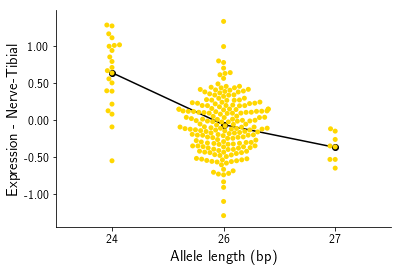

In [23]:
chrom = "chr9"
start = 26979150
end = 26979161
gene = "ENSG00000096872.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IFT74.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PRR12
gwas scz

Skin-NotSunExposed 4.750055976423412e-09 0.3973796543553447
Thyroid 3.493237190532509e-15 0.4673040501132752
Lung 6.30836488207937e-06 0.2812274575817545
Esophagus-Mucosa 6.711393636813602e-10 0.38131194593544215
Adipose-Visceral 0.0004508323070361784 0.25538208933057466
Skin-SunExposed 1.175747189389655e-11 0.3857991122470982
Nerve-Tibial 0.0012323970211772007 0.2016559463167942


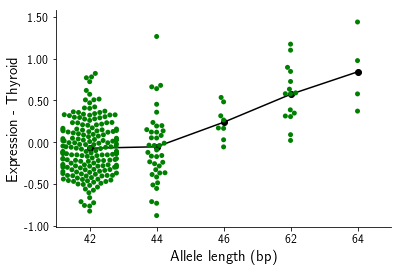

In [24]:
chrom = "chr19"
start = 50110619
end = 50110638
gene = "ENSG00000126464.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PRR12.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 4.9806819672565714e-14 0.5075041128880974
Esophagus-Mucosa 1.5974907272681155e-13 0.4569143901205725
Adipose-Visceral 6.715046934209823e-05 0.2918351516208077
Skin-SunExposed 2.3980939305436036e-19 0.5099821796879951
Nerve-Tibial 4.8688583524480785e-06 0.2884214963651902


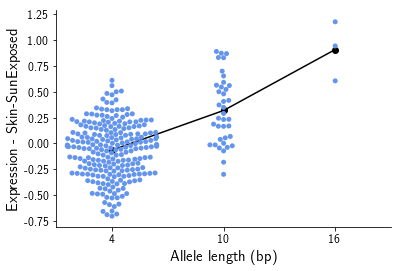

In [25]:
chrom = "chr19"
start = 50093218
end = 50093218
gene = "ENSG00000126464.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PRR12_2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ARPP19
gwas scz

Skin-NotSunExposed 4.54413246511223e-11 0.4380757014332468
Thyroid 3.5746972789680354e-21 0.5419470790577885
Esophagus-Mucosa 3.1109577853526553e-21 0.5489379325602957
Adipose-Visceral 1.849935777274995e-11 0.4603046306890484
Cells-Transformedfibroblasts 5.804823683281639e-13 0.4570759689656684
Muscle-Skeletal 6.396899351555801e-08 0.28807506747397305
Adipose-Subcutaneous 9.901826052337064e-24 0.5612972169202302
Skin-SunExposed 1.5243607907852434e-21 0.5152820876549652
WholeBlood 9.231827253120986e-05 0.2126083276417827
Artery-Tibial 3.4939618171604863e-14 0.4373722579067922
Artery-Aorta 4.648236020334798e-13 0.4935486814943235
Heart-LeftVentricle 1.3119471523757718e-07 0.3661129323302583
Nerve-Tibial 1.1819630931880026e-20 0.5323996440468451


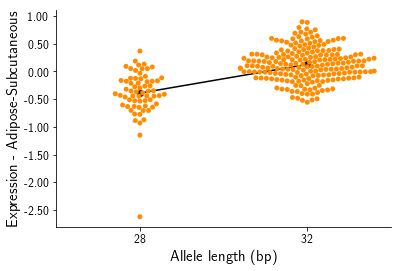

In [26]:
chrom = "chr15"
start = 52854833
end = 52854847
gene = "ENSG00000128989.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ARPP19.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VSIG2
gwas scz

Cells-Transformedfibroblasts 0.005038504450630657 0.18761463830799624
Muscle-Skeletal 0.0017915488820116558 0.1692564332824802
Adipose-Subcutaneous 6.019106409844808e-08 0.32411681078318744
Skin-SunExposed 5.993537488184197e-05 0.2326151713402061
Artery-Tibial 0.002537318458868361 0.18268118663184604
Nerve-Tibial 0.007392020076654942 0.16545397873479867


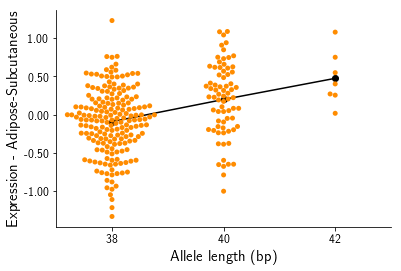

In [27]:
chrom = "chr11"
start = 124621018
end = 124621035
gene = "ENSG00000019102.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VSIG2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# FKBPL
scz gwas

Skin-SunExposed 1.4045971057133373e-05 0.2524237163103265
WholeBlood 0.004187371134715581 -0.15869784391703026


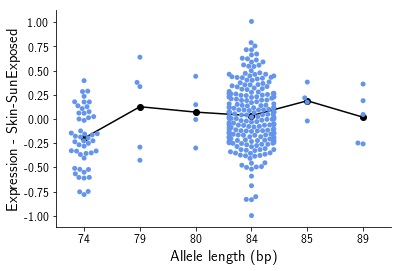

In [28]:
chrom = "chr6"
start = 32066234
end = 32066274
gene = "ENSG00000204315.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FKBPL.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# DCLK3
autism gwas

Skin-NotSunExposed 3.682076145259664e-05 0.2874137799607485


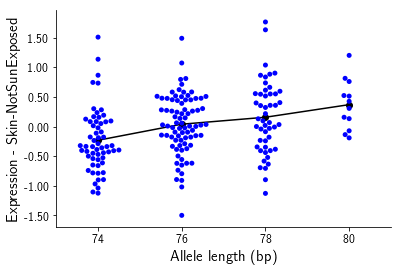

In [29]:
chrom = "chr3"
start = 36835922
end = 36835957
gene = "ENSG00000163673.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DCLK3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# EXOG
scz gwas

Cells-Transformedfibroblasts 0.00026724027352330315 -0.2445278093488739
Muscle-Skeletal 1.239713698089676e-06 -0.25942324743330786


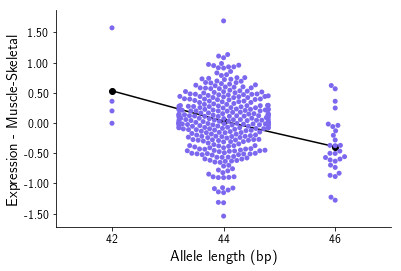

In [30]:
chrom = "chr3"
start = 38476818
end = 38476838
gene = "ENSG00000157036.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EXOG.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GLS
blood gwas

Esophagus-Muscularis 0.00029763147944741116 -0.24896060983340795
Esophagus-Mucosa 5.059282945521411e-06 -0.2867960625608881
Muscle-Skeletal 4.562020017696082e-09 -0.3142642099094985
Adipose-Subcutaneous 0.00017868697786645754 -0.2282333774524605
Heart-LeftVentricle 0.00033731520658148784 -0.2573732588425641
Nerve-Tibial 0.0039066339104463325 -0.17906509667658835


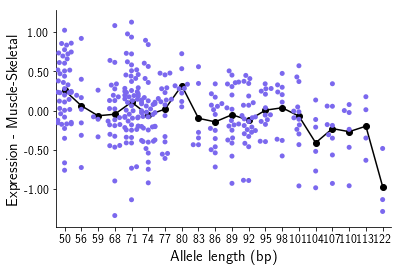

In [31]:
chrom = "chr2"
start = 191745599
end = 191745646
gene = "ENSG00000115419.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GLS.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PCSK9
gwas ldl

Lung 0.0075843042093467206 -0.1658814791504925
Brain-Cerebellum 0.006320535919911228 -0.2624229688397727
WholeBlood 4.991449330755587e-05 -0.22003491841534192


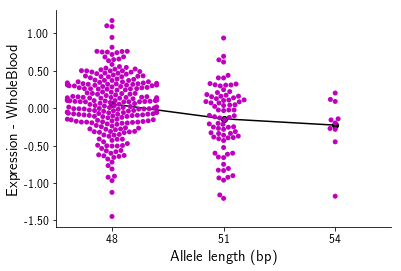

In [32]:
chrom = "chr1"
start = 55505553
end = 55505575
gene = "ENSG00000169174.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PCSK9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ASCC2
gwas
bipolar

Brain-Cerebellum 1.1147113959663748e-05 0.4124781661518796
WholeBlood 0.0004081635520371792 0.19405614764307588


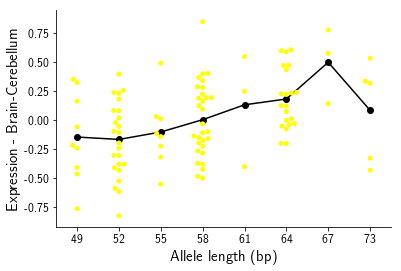

In [33]:
chrom = "chr22"
start = 30234193
end = 30234217
gene = "ENSG00000100325.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ASCC2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# TMEM158
gwas scz

Brain-Cerebellum 1.6339004475994153e-06 -0.5037646418625312


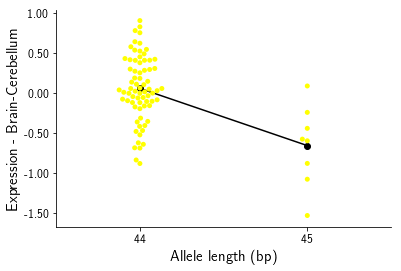

In [34]:
chrom = "chr3"
start = 45297762
end = 45297782
gene = "ENSG00000249992.1"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TMEM158.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CCDC137
gwas cholesterol

Skin-NotSunExposed 3.8971520712025266e-05 0.3015353802850565
Esophagus-Muscularis 2.223058830646622e-05 0.30636601712620537
Thyroid 1.5788172216903009e-06 0.3072136546607862
Lung 1.912194626968764e-10 0.40818565696801545
Esophagus-Mucosa 4.185168062815647e-06 0.30393102752635226
Adipose-Visceral 2.84996450348151e-05 0.31509482386380444
Adipose-Subcutaneous 3.536608511772432e-07 0.32161378877125485
Skin-SunExposed 8.157450492113927e-07 0.3013232432815384
WholeBlood 7.12650419211863e-10 0.35066409182094044
Artery-Aorta 1.7512384442686553e-06 0.3611449068248533
Heart-LeftVentricle 0.007548194794949495 0.20019402248215154
Nerve-Tibial 3.5391464010534315e-08 0.350724945278029


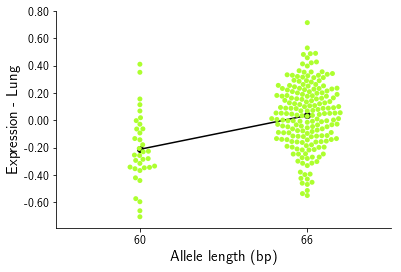

In [35]:
chrom = "chr17"
start = 79667664
end = 79667695
gene = "ENSG00000185298.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CCDC137.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# L1TD1
gwas pediatric bone

Skin-NotSunExposed 3.776219304197391e-08 -0.3938716953119884
Esophagus-Muscularis 2.1428061042287465e-14 -0.5196653731763242
Thyroid 4.026677993035952e-17 -0.5150926279789009
Lung 5.874753738563325e-07 -0.32097175289751545
Esophagus-Mucosa 0.002371859515475145 -0.1994697286423544
Adipose-Visceral 3.3799141608050397e-12 -0.5024761613503977
Cells-Transformedfibroblasts 3.6958883643334884e-23 -0.6297079103810029
Muscle-Skeletal 6.68799996761699e-07 -0.28002927517480874
Adipose-Subcutaneous 6.6144068831420764e-24 -0.5900643155911631
Skin-SunExposed 3.781866912819568e-15 -0.457258463787894
Artery-Tibial 2.512913347644224e-13 -0.4427073141169179
Artery-Aorta 4.2225446238689225e-08 -0.4085647269530128
Nerve-Tibial 1.1321902546122027e-25 -0.6122814616773267


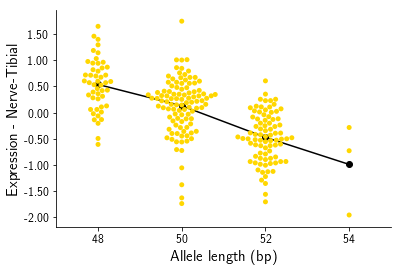

In [36]:
chrom = "chr1"
start = 62650593
end = 62650617
gene = "ENSG00000240563.1"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_L1TD1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# FAM154B
cognitive ability gwas

Skin-NotSunExposed 2.6603695357651003e-10 -0.4544597997145975
Esophagus-Muscularis 0.00013308151333712312 -0.2715956891643639
Thyroid 2.08981841205612e-07 -0.3370244520267596
Lung 0.00327303990286567 -0.1943992747533036
Esophagus-Mucosa 2.4001669816811903e-07 -0.33686745596229634
Brain-Cerebellum 0.000494083614178529 -0.35798296072300395
Adipose-Visceral 6.630726435780477e-08 -0.4076473637654385
Cells-Transformedfibroblasts 5.506867838025484e-10 -0.4188679798515417
Muscle-Skeletal 1.1542215615277694e-05 -0.2506418800860439
Adipose-Subcutaneous 1.0193608413700073e-07 -0.33669940563641315
Skin-SunExposed 1.1262023382531927e-08 -0.34426222405742657
WholeBlood 3.6827153910353844e-11 -0.3722329458345276
Artery-Tibial 7.87125713775114e-11 -0.4015508357689577
Artery-Aorta 2.948513517978429e-11 -0.4828937136252156
Heart-LeftVentricle 1.0468019102176264e-09 -0.441763333475821
Nerve-Tibial 2.4509914146152347e-08 -0.35818030537360285


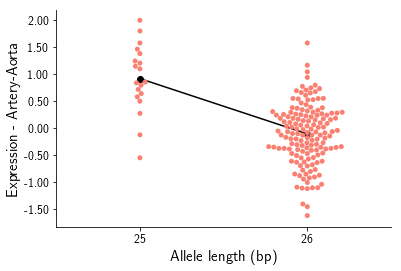

In [37]:
chrom = "chr15"
start = 82475166
end = 82475177
gene = "ENSG00000188659.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FAM154B.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NRBP2
SCZ gwas

Thyroid 7.901385761986984e-05 0.25407189644284073
Skin-SunExposed 0.005350701649980046 -0.16937224948983304


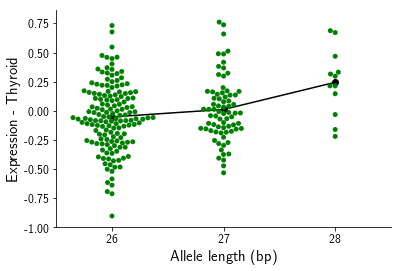

In [38]:
chrom = "chr8"
start = 144839147
end = 144839158
gene = "ENSG00000185189.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NRBP1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NLRX1
platelet count


Cells-Transformedfibroblasts 0.00023736610130911933 0.2493208699802991


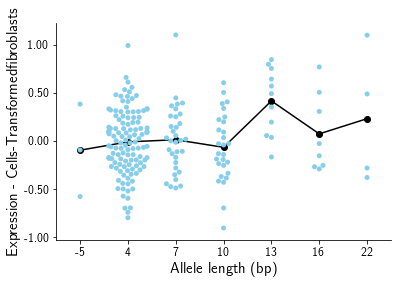

In [39]:
chrom = "chr11"
start = 119077000
end = 119077000
gene = "ENSG00000160703.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NLRX1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SLC36A1
basophil perc gwas

Skin-NotSunExposed 6.857084709486592e-07 0.346714771992448
Esophagus-Muscularis 9.211279672433607e-12 0.4549059947282375
Thyroid 1.1172355363734894e-22 0.567132316593502
Lung 1.7760292965720314e-14 0.464740791648959
Esophagus-Mucosa 8.542845236578954e-06 0.28064660512933226
Adipose-Visceral 5.277235398258113e-07 0.3635284319275533
Cells-Transformedfibroblasts 0.001103534675314384 0.22310151112802085
Muscle-Skeletal 0.002530850345695498 0.1679951845063919
Adipose-Subcutaneous 4.595197997388511e-13 0.4335625383093324
Skin-SunExposed 1.0493718491097452e-16 0.4688129134561948
WholeBlood 4.985878972190114e-13 0.3916737404221777
Artery-Tibial 5.1157162563565815e-14 0.4437336174928944
Artery-Aorta 6.698045980176985e-07 0.35669407417977744
Heart-LeftVentricle 0.0003562076470956366 0.2563847622610408
Nerve-Tibial 8.782494133869328e-14 0.4478207427918647


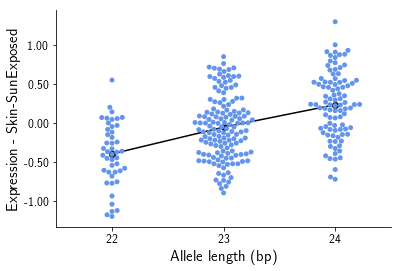

In [40]:
chrom = "chr5"
start = 150848654
end = 150848664
gene = "ENSG00000123643.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
best_tissue = "Skin-SunExposed"
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SLC36A1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SIGLEC5
blood protein gwas

WholeBlood 9.931570643516584e-09 -0.3098510005941527


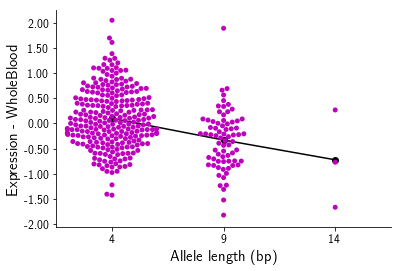

In [41]:
chrom = "chr19"
start = 52130149
end = 52130149
gene = "ENSG00000105501.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SIGLEC5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GPD1L
scz gwas

Thyroid 1.125566104796442e-20 0.5405704422090214
Lung 6.0023311978711925e-06 0.28077023011786073
Esophagus-Mucosa 5.123229796000169e-06 0.2860729563755484


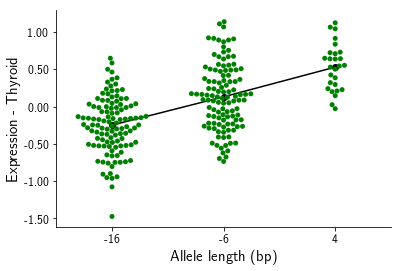

In [42]:
chrom = "chr3"
start = 32083114
end = 32083114
gene = "ENSG00000152642.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GPD1L.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# SERINC2
heart rate https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5832790/

Esophagus-Muscularis 0.00017354905819911437 0.2624725465694134
Lung 0.004993217899405453 0.17669159320770714
Esophagus-Mucosa 0.0036878029180786717 0.18753355470156666
Adipose-Visceral 0.0011080364842690146 0.2366970239971613
Cells-Transformedfibroblasts 3.5990561318678418e-09 0.3896513121765178
Muscle-Skeletal 0.00044106571421935286 0.19324132128743
Adipose-Subcutaneous 1.0418054480828764e-05 0.2701167466755467
WholeBlood 3.996586951213779e-13 0.39031896275652295
Artery-Tibial 1.5650395645447276e-10 0.3813761177638634
Artery-Aorta 8.725958006304493e-07 0.3550714187027919


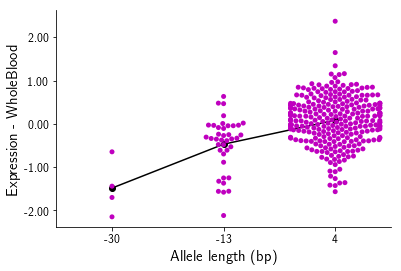

In [43]:
chrom = "chr1"
start = 31886001
end = 31886001
gene = "ENSG00000168528.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SERINC2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IRF5
autoimmune gwas

Skin-NotSunExposed 0.00017710764787707344 0.2596053352561553
Esophagus-Muscularis 0.001742564190891924 0.21790734461555167
Thyroid 7.199836320260566e-08 0.3288331213077018
Lung 8.03556247046095e-08 0.33141699044003303
Esophagus-Mucosa 5.978753089285937e-10 0.3823523166163335
Adipose-Visceral 0.0023021977000203552 0.2210304624637015
Cells-Transformedfibroblasts 1.5344972627196415e-05 0.2908492183378725
Muscle-Skeletal 0.0066400717428441065 0.14892611901270705
Adipose-Subcutaneous 0.004852085661823441 0.17319522934411444
Skin-SunExposed 8.750973930566279e-09 0.3303154672824102
WholeBlood 2.460512158718625e-15 0.4196161707481047
Artery-Tibial 3.0661122382709327e-07 0.30713426070748057
Brain-Caudate 0.0051381528137544215 0.2724715509161179
Artery-Aorta 0.0010797254791681434 0.2372137907010804
Nerve-Tibial 1.0973551762069028e-07 0.3256480487050753


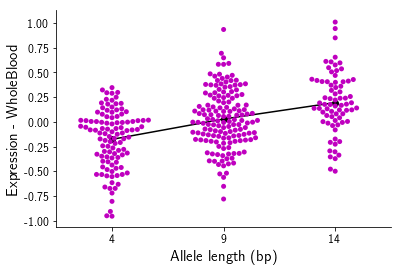

In [44]:
chrom = "chr7"
start = 128577915
end = 128577915
gene = "ENSG00000128604.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IRF5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CARD9
gwas

Cells-Transformedfibroblasts 0.0019384260051748504 0.21024261012669532
Muscle-Skeletal 2.872941418694877e-05 0.2270958025884247
WholeBlood 0.006778809077851694 -0.15060829306819495


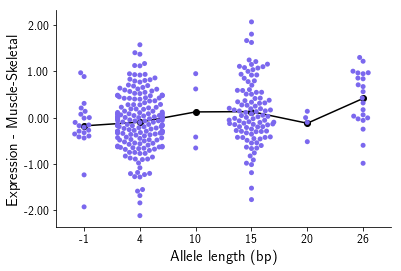

In [45]:
chrom = "chr9"
start = 139258185
end = 139258185
gene = "ENSG00000187796.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CARD9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# IGSF9B
gwas scz/asd

Thyroid 4.545720067990943e-16 -0.4746310865989592
WholeBlood 1.767376132816974e-06 -0.25912277877086937
Artery-Tibial 0.0019627255699341283 -0.1865753970666892
Nerve-Tibial 0.0038121087966161656 -0.17816852129272426


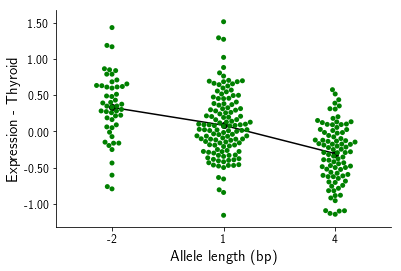

In [46]:
chrom = "chr11"
start = 133820762
end = 133820762
gene = "ENSG00000080854.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IGSF9B.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RASIP1
crohn's disease gwas

Esophagus-Mucosa 8.667466186815802e-15 -0.4645765736392843
Skin-NotSunExposed 0.0005649846211891737 -0.2370793752057113
Cells-Transformedfibroblasts 5.889123728669612e-12 -0.4441957678605821
Skin-SunExposed 2.336103590388474e-07 -0.29601909022821554


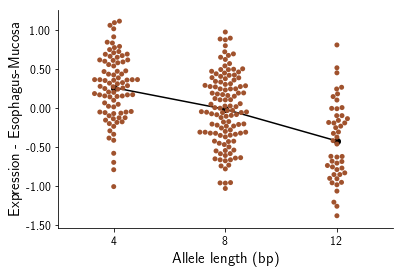

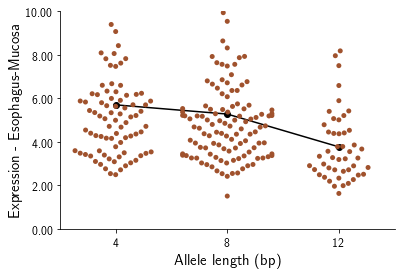

In [17]:
chrom = "chr19"
start = 49232030
end = 49232030
gene = "ENSG00000105538.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RASIP1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=10)

Esophagus-Mucosa 1.7214094893140673e-05 -0.2945940358507715
Skin-NotSunExposed 0.0013745071371574734 -0.2323506314462601
Cells-Transformedfibroblasts 3.205475564296556e-05 -0.3105524906606613
WholeBlood 0.00029485778369653213 -0.21823820451343132
Skin-SunExposed 1.1371000834695335e-05 -0.27635571015631066


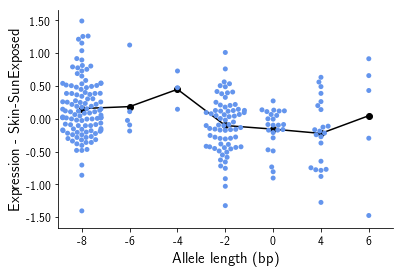

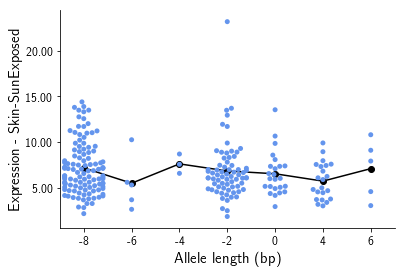

In [14]:
# PDGFB
chrom = "chr22"
start = 39639216
end = 39639216
gene = "ENSG00000100311.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PDGFB.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=None)

Artery-Tibial 8.809633192897377e-07 -0.3092253446761948
Thyroid 3.297761323167882e-06 -0.30439505059294
Adipose-Subcutaneous 1.949049852521992e-05 -0.27581674561232056
WholeBlood 5.303201444033632e-11 -0.3753901140148448
Heart-LeftVentricle 0.0007047778434007964 -0.2573345614990376
Esophagus-Muscularis 1.044735309558487e-06 -0.35360668961653097
Lung 0.00589075409903339 -0.18067344193813686
Adipose-Visceral 1.5533059298541285e-05 -0.33236102343643786
Muscle-Skeletal 0.0024348824394667 -0.1749782711242552


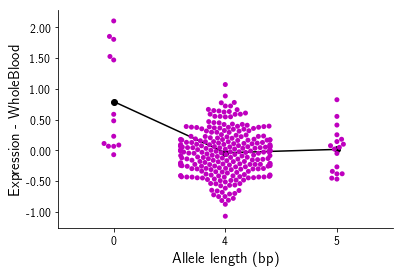

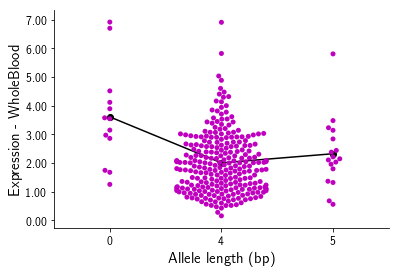

In [15]:
# RAPGEFL1
chrom = "chr17"
start = 38236658
end = 38236658
gene = "ENSG00000108352.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RAPGEFL1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=None)

# MKRN2
cholesterol gwas

Skin-NotSunExposed 2.006827027749236e-06 -0.3248831530488701
Esophagus-Muscularis 0.0022227120032904226 -0.20898598848040112
Lung 0.0018787509778552683 -0.19340611126942453
Esophagus-Mucosa 1.9155238850882357e-06 -0.2953263464374561
Cells-Transformedfibroblasts 4.201520142260756e-07 -0.3310724935467212
Muscle-Skeletal 8.350580976282615e-27 -0.5371204761028917
Adipose-Subcutaneous 0.001073849543360352 -0.19870617423347264
Skin-SunExposed 8.374567575091696e-07 -0.2817145885903978
WholeBlood 2.2507701841385142e-05 -0.23034787386603384
Artery-Tibial 2.6644371334755414e-15 -0.4541984857760834
Artery-Aorta 4.553835844360116e-06 -0.32644733156187666
Heart-LeftVentricle 1.1284291683169515e-06 -0.33866833219188


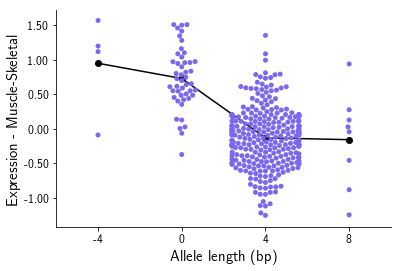

In [48]:
chrom = "chr3"
start = 12625265
end = 12625265
gene = "ENSG00000075975.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MKRN2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CCDC137,OXLD1
cholesterol

Skin-NotSunExposed 3.8971520712025266e-05 0.3015353802850565
Esophagus-Muscularis 2.223058830646622e-05 0.30636601712620537
Thyroid 1.5788172216903009e-06 0.3072136546607862
Lung 1.912194626968764e-10 0.40818565696801545
Esophagus-Mucosa 4.185168062815647e-06 0.30393102752635226
Adipose-Visceral 2.84996450348151e-05 0.31509482386380444
Adipose-Subcutaneous 3.536608511772432e-07 0.32161378877125485
Skin-SunExposed 8.157450492113927e-07 0.3013232432815384
WholeBlood 7.12650419211863e-10 0.35066409182094044
Artery-Aorta 1.7512384442686553e-06 0.3611449068248533
Heart-LeftVentricle 0.007548194794949495 0.20019402248215154
Nerve-Tibial 3.5391464010534315e-08 0.350724945278029


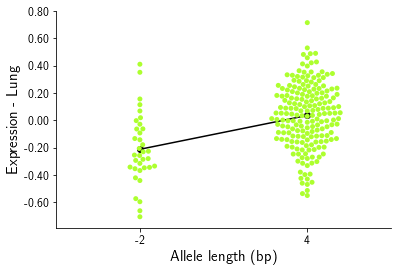

In [49]:
chrom = "chr17"
start = 79667664
end = 79667664
gene = "ENSG00000185298.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CCDC137.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# LCAT
cholesterol gwas

WholeBlood 2.3596863738620944e-08 -0.3328379469245061


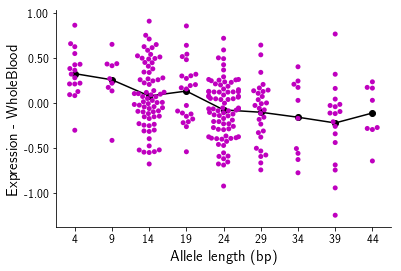

In [50]:
chrom = "chr16"
start = 68014740
end = 68014740
gene = "ENSG00000213398.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_LCAT.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# NPRL3
blood gwas

Skin-NotSunExposed 3.0272502608744046e-13 -0.4880465251375807
Esophagus-Muscularis 2.581294069633389e-17 -0.5458515297230118
Thyroid 7.357110677658813e-13 -0.4332171676056555
Lung 3.9410244756731695e-18 -0.5149822974129588
Esophagus-Mucosa 4.873900487174692e-13 -0.4435658624573575
Brain-Cerebellum 7.588008143862597e-10 -0.5602394816225938
Adipose-Visceral 3.929112756560687e-11 -0.4680633168836372
Cells-Transformedfibroblasts 2.7142231183344722e-08 -0.3686887492262511
Muscle-Skeletal 5.684921218874342e-15 -0.41632652023924505
Adipose-Subcutaneous 1.556821459615462e-22 -0.5581932319276508
Skin-SunExposed 1.0453210019715316e-15 -0.4549085907093791
Artery-Tibial 3.3769169221837104e-09 -0.35308443675271456
Brain-Caudate 3.7236817102079556e-08 -0.5144719393931253
Artery-Aorta 6.7063762981744224e-18 -0.5808707909612547
Heart-LeftVentricle 6.18290372557741e-11 -0.4526461939710994
Nerve-Tibial 4.895001747449874e-20 -0.5392629727990816


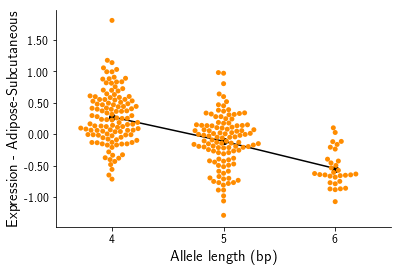

In [51]:
chrom = "chr16"
start = 186525
end = 186525
gene = "ENSG00000103148.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NPRL3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PAX8

Skin-NotSunExposed 3.2713032736089117e-21 -0.5961589409889411
Esophagus-Muscularis 1.472718522989775e-19 -0.5675508405044395
Lung 2.4519282289986135e-16 -0.4808976126102635
Esophagus-Mucosa 7.620450672701108e-21 -0.5425714830131302
Adipose-Visceral 1.8303025402972879e-16 -0.5483356239084642
Cells-Transformedfibroblasts 3.7644449083105677e-16 -0.5107578702929808
Muscle-Skeletal 1.949902951589941e-13 -0.3841720088961015
Adipose-Subcutaneous 5.596743971310913e-26 -0.5847604828109519
Skin-SunExposed 6.875337293660186e-24 -0.5416394139165275
WholeBlood 1.0492893382714712e-19 -0.4694083048803913
Artery-Tibial 3.3394411804900586e-24 -0.5627358354169372
Brain-Caudate 3.348384644539741e-06 -0.4321626658624211
Artery-Aorta 2.426861798677945e-25 -0.6608330035014415
Heart-LeftVentricle 1.2471119389384633e-15 -0.5283423965635321
Nerve-Tibial 1.2258659905196505e-29 -0.6236417968408379


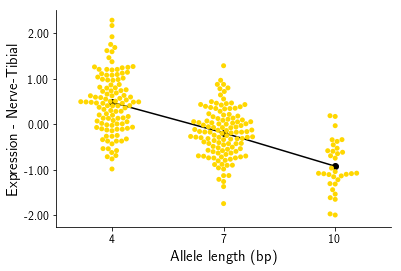

In [52]:
chrom = "chr2"
start = 113984226
end = 113984226
gene = "ENSG00000125618.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PAX8.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RASGRP3

Skin-NotSunExposed 1.1970907689270026e-09 0.42101267139423626
Esophagus-Muscularis 3.830379078639391e-05 0.29180204811336113
Thyroid 3.4514916052873245e-17 0.5048942285918738
Lung 2.435084332736508e-07 0.32711371759395985
Esophagus-Mucosa 5.59142644034964e-06 0.29074484081984475
Brain-Cerebellum 4.528566303648316e-06 0.4487466372925006
Adipose-Visceral 2.0575228217641157e-05 0.317649189876144
Muscle-Skeletal 1.866858535407385e-07 0.28943533736863297
Skin-SunExposed 1.0010357910295393e-09 0.3596173922910565
WholeBlood 0.0022207006614131165 0.1739634389258655
Artery-Tibial 0.0064795486090845926 0.17007952896283934
Artery-Aorta 0.005517750576229175 0.21198327237815034
Heart-LeftVentricle 7.567050280550641e-15 0.5321951277546911
Nerve-Tibial 1.7925323729431408e-06 0.3001822923684254


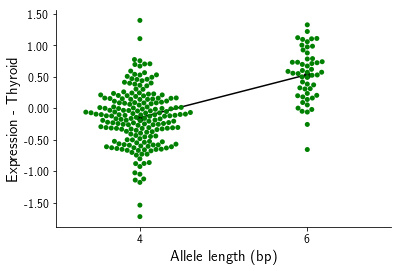

In [53]:
chrom = "chr2"
start = 33762260
end = 33762260
gene = "ENSG00000152689.13"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RASGRP3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# VGLL2

Esophagus-Mucosa 4.878328526986629e-09 0.3700332758225506


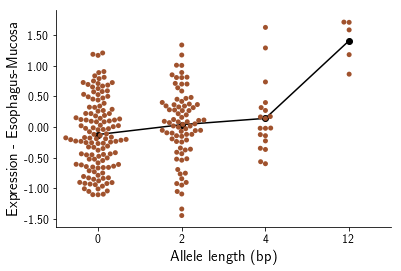

In [54]:
chrom = "chr6"
start = 117524057
end = 117524057
gene = "ENSG00000170162.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VGLL2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# TMPRSS9

Skin-SunExposed 0.0036314173646097257 0.17451900375657625
WholeBlood 6.495764798398849e-14 0.4111896705464189


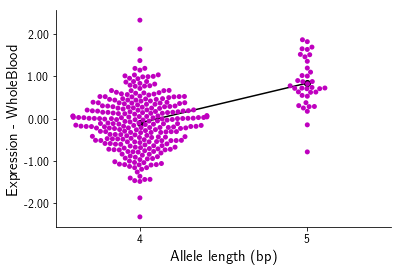

In [55]:
chrom = "chr19"
start = 2421294
end = 2421294
gene = "ENSG00000178297.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TMPRSS9.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# HTATIP2

Esophagus-Muscularis 1.6834170610711692e-19 0.571259588851503
Lung 6.871457442180584e-05 0.2466308523494353
Esophagus-Mucosa 3.7495079998907177e-05 -0.25912221318108397
Brain-Cerebellum 0.003808393983317469 0.2787639177309794
Adipose-Visceral 1.6435970487329048e-14 0.5228327675545665
Cells-Transformedfibroblasts 2.5104935713554784e-32 0.6891168908185997
Muscle-Skeletal 4.7615915598599604e-08 0.2915862523038166
Adipose-Subcutaneous 2.5016008651659257e-34 0.657616562060935
WholeBlood 0.007640847290725506 0.14682728208735293
Artery-Tibial 6.3547866104516485e-18 0.4935622835463453
Brain-Caudate 0.0034461303426877032 0.2803560046929972
Artery-Aorta 9.651960729008126e-15 0.5291841782258672
Heart-LeftVentricle 9.164537727197323e-12 0.4621723421602947
Nerve-Tibial 5.977624934532001e-32 0.6476304313862666


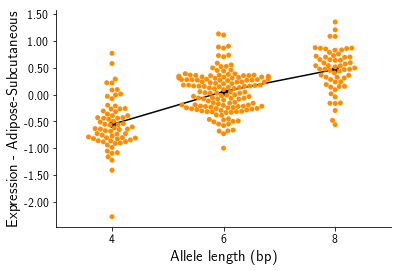

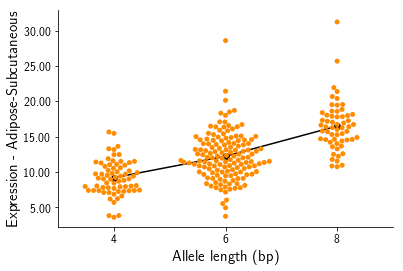

In [56]:
chrom = "chr11"
start = 20384871
end = 20384871
gene = "ENSG00000109854.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_HTATIP2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=None)

# SMYD4
Blood_protein_levels

Skin-NotSunExposed 2.207557263778761e-05 0.2916450731939681
Esophagus-Muscularis 7.198562515242941e-06 0.3055360864159952
Thyroid 2.811584850136219e-15 0.4654720816937326
Lung 7.197481798495317e-05 0.2464418780399161
Esophagus-Mucosa 0.00017496519043970463 0.2361093455448671
Brain-Cerebellum 0.00285710709529168 0.28968141549375737
Adipose-Visceral 0.0003020049505121367 0.2600375220450829
Muscle-Skeletal 2.9399588268090413e-05 0.2248398869226687
Adipose-Subcutaneous 5.831898564703277e-08 0.3261897170118524
Skin-SunExposed 3.3600434211180483e-08 0.3151247147400843
WholeBlood 0.0014009946054437238 0.17594695180437836
Artery-Tibial 2.938920275448392e-07 0.3054014030953813
Brain-Caudate 0.0012924628030778276 0.30852289371198904
Heart-LeftVentricle 0.000489297189600156 0.2480002360964056
Nerve-Tibial 4.3732088351863444e-07 0.3060524802334957


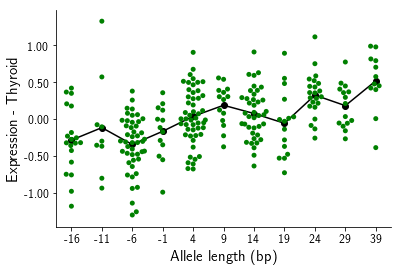

In [57]:
chrom = "chr17"
start = 1682774
end = 1682774
gene = "ENSG00000186532.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SMYD4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# EXOC3

Esophagus-Muscularis 4.529487478854264e-11 0.4565877628674536
Thyroid 0.002345337057192233 0.1971564217707783
Lung 3.869563999237348e-12 0.4403922724674031
Esophagus-Mucosa 9.574701949102703e-08 0.34722480295380165
Brain-Cerebellum 7.669455550360116e-05 0.3963426439408418
Adipose-Visceral 4.681022686265251e-05 0.30692649052426235
Muscle-Skeletal 6.050752487079279e-13 0.3980221988102511
Adipose-Subcutaneous 0.0023620152813510213 0.19418811210944506
WholeBlood 1.3539198989883802e-10 0.3637452905994316
Artery-Tibial 3.580823408181425e-11 0.4081662925159461
Artery-Aorta 0.00019034727945445702 0.2899973792239334
Heart-LeftVentricle 0.002285371492314771 0.2291544073833147


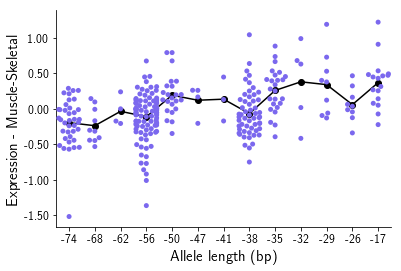

In [58]:
chrom = "chr5"
start = 443336
end = 443336
gene = "ENSG00000180104.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EXOC3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# ESR2

Lung 0.006144904418164093 0.1714900202044364
Esophagus-Mucosa 0.007379222344881056 0.16941254921311774
Brain-Cerebellum 1.831444906641296e-06 0.4424117641515044
Muscle-Skeletal 0.00010574330656177748 0.20870950679936515
Skin-SunExposed 4.2114673057707715e-23 0.535066845966037
WholeBlood 8.598648661353008e-08 0.289496631524331
Nerve-Tibial 0.006545834054280032 0.16759853989613094


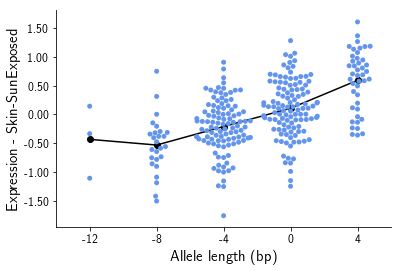

In [59]:
chrom = "chr14"
start = 64724929
end = 64724929
gene = "ENSG00000140009.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ESR2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PRR12

Skin-NotSunExposed 1.234578358836417e-08 -0.3846876261254871
Esophagus-Muscularis 0.00020701982589827627 -0.2539492117059841
Thyroid 1.4434488021266786e-11 -0.40217588880760696
Lung 2.927459928176654e-05 -0.25703892753234475
Esophagus-Mucosa 1.6399582790571873e-10 -0.38935460807121375
Brain-Cerebellum 1.6487831007183774e-05 -0.4051293414875004
Adipose-Visceral 0.0017704037189333552 -0.22654556002520704
Cells-Transformedfibroblasts 0.004715633997935474 -0.18943682474520035
Muscle-Skeletal 0.0013212574434594234 -0.17398338221206588
Adipose-Subcutaneous 1.2408681966174365e-05 -0.2634575676505865
Skin-SunExposed 3.2863112000365864e-07 -0.2929902304262291
Artery-Tibial 0.0065443696463251535 -0.16420722249644062
Artery-Aorta 0.0004534941260472402 -0.2532675702209625
Heart-LeftVentricle 3.869453107242836e-06 -0.323054708398429
Nerve-Tibial 3.104120718632427e-10 -0.3769052714108199


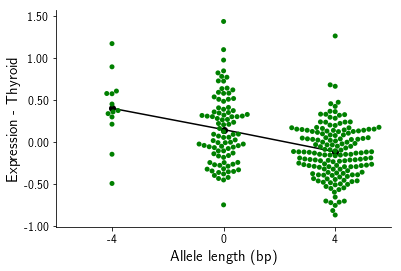

In [60]:
chrom = "chr19"
start = 50083547
end = 50083547
gene = "ENSG00000126464.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PRR12.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GALNT2

Artery-Aorta 2.248764404534748e-05 -0.3162409020210092


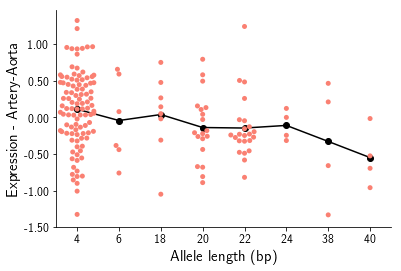

In [61]:
chrom = "chr1"
start = 230264005
end = 230264005
gene = "ENSG00000143641.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GALNT2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# DYNC1I2

Thyroid 0.00971115122952232 0.173611268475875
Cells-Transformedfibroblasts 4.728571087784242e-10 0.42717431008843015
Muscle-Skeletal 6.018307269298608e-09 0.3288892522422259
Adipose-Subcutaneous 5.164733520088451e-12 0.4320369747763089
Skin-SunExposed 2.311543694505057e-07 0.3158839748017045
Artery-Tibial 3.285116865273006e-08 0.3486973070754483


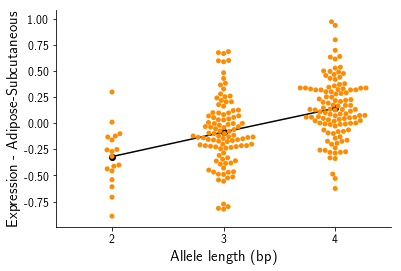

In [62]:
chrom = "chr2"
start = 172569135
end = 172569135
gene = "ENSG00000077380.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DYNC1I2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# RFT1

Skin-NotSunExposed 5.068441036499481e-07 0.3621578032579121
Esophagus-Muscularis 1.7994635063290856e-24 0.6582648642457852
Thyroid 5.520449095903695e-20 0.5591089474995059
Lung 5.290932317579176e-06 0.2995390615130402
Esophagus-Mucosa 2.7123554598485613e-08 0.3639331498775384
Brain-Cerebellum 1.470869320238301e-11 0.6398862587357226
Adipose-Visceral 5.850854394005191e-07 0.3752071146637285
Cells-Transformedfibroblasts 7.256750372254043e-08 0.3785117874774329
Muscle-Skeletal 2.0871598717681136e-07 0.29524050486348385
Adipose-Subcutaneous 1.0164963568144208e-15 0.4900285753865905
Skin-SunExposed 1.7311089574216045e-06 0.292078775090833
WholeBlood 6.086498722325403e-05 0.2335903505366913
Artery-Tibial 1.875830650265948e-24 0.5938224449716818
Brain-Caudate 8.380816504635875e-06 0.44375591538527176
Artery-Aorta 5.169004081157927e-20 0.6248445779828318
Heart-LeftVentricle 8.799082046513962e-10 0.4482563202113437
Nerve-Tibial 3.185315539057736e-13 0.4535620263880949


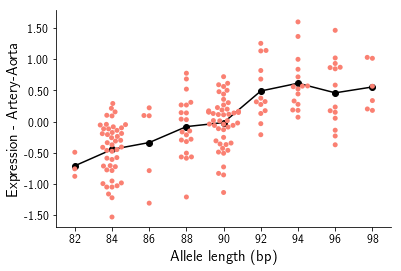

In [63]:
chrom = "chr3"
start = 53128363
end = 53128413
gene = "ENSG00000163933.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
best_tissue = "Artery-Aorta"
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_RFT1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# FADS1

Thyroid 3.080488549773928e-05 0.25880810528416803
Esophagus-Mucosa 4.44064994823136e-05 0.2572549521080461
Brain-Cerebellum 5.7179943215555834e-08 0.5018644628118429
Muscle-Skeletal 0.0015721797417056235 0.17205832833358378


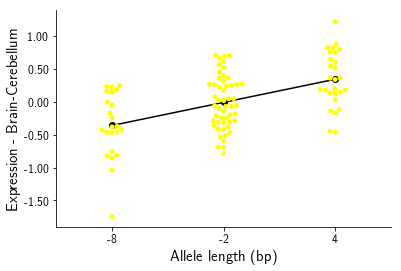

In [64]:
chrom = "chr11"
start = 61620629
end = 61620629
gene = "ENSG00000149485.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FADS1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# GNL3

Esophagus-Muscularis 0.0019663727297502555 -0.2203424527133317
Brain-Cerebellum 0.0010241104164805748 -0.3334145348092866
Cells-Transformedfibroblasts 3.916421650732448e-07 -0.3438667984910537
Muscle-Skeletal 0.00013610334705212312 -0.21604609822163084
Adipose-Subcutaneous 0.000878165462258428 -0.20830720900842672
Artery-Tibial 0.001841413702843925 -0.19683858095727647
Artery-Aorta 0.0007088196187166293 -0.2535886862841973
Heart-LeftVentricle 0.006984783443169261 -0.20097233847184373
Nerve-Tibial 2.5494547993307124e-05 -0.27264252156805924


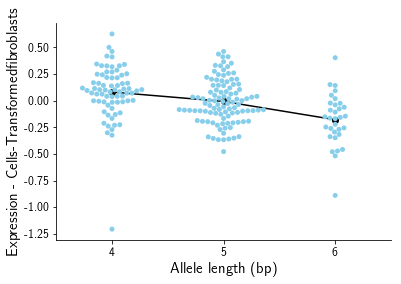

In [65]:
chrom = "chr3"
start = 52801574
end = 52801574
gene = "ENSG00000163938.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GNL3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# PLCD4
test height neg example?

Muscle-Skeletal 0.00012185985999398356 -0.22411052932943235
Nerve-Tibial 0.009175029527481737 0.17183162681121975


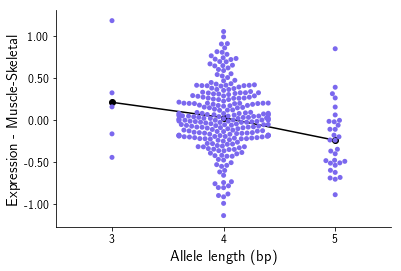

In [66]:
chrom = "chr2"
start = 219467421
end = 219467421
gene = "ENSG00000115556.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PLCD4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# CEBPZ

Skin-NotSunExposed 7.635462398082737e-05 -0.2829474801667376
Esophagus-Muscularis 0.001297600002865209 -0.22874794547949984
Thyroid 1.650636062567542e-05 -0.2735847636897349
Lung 5.7404538521840735e-05 -0.2577252716730837
Esophagus-Mucosa 1.3789876982818994e-10 -0.40533872368481255
Adipose-Visceral 0.005152944691365993 -0.21118879456063275
Cells-Transformedfibroblasts 0.00014790364405058037 -0.2651593139985078
Muscle-Skeletal 7.634216177036411e-05 -0.2199626526590477
Adipose-Subcutaneous 2.996650452998621e-07 -0.3209384966324213
Skin-SunExposed 4.552258827819654e-06 -0.2729273636563662
Artery-Tibial 0.00031024650327008264 -0.2262693834558508
Artery-Aorta 9.739697266537375e-09 -0.4155569420853405
Nerve-Tibial 7.675558783387976e-11 -0.4002454852071802


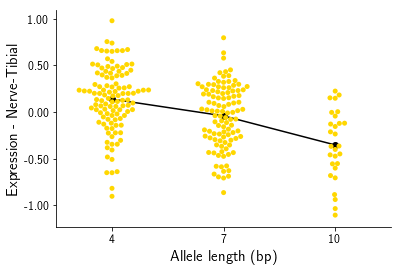

In [67]:
chrom = "chr2"
start = 37551759
end = 37551759
gene = "ENSG00000115816.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CEBPZ.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# TM6SF2

Thyroid 4.653570528143676e-08 -0.3377419364751977
Lung 4.754623321320968e-07 0.3138876039042868
Brain-Cerebellum 5.736921723771967e-06 -0.4341484269889436
Adipose-Visceral 5.208529684822029e-05 -0.2944533864233743
Cells-Transformedfibroblasts 9.750301732727742e-08 -0.3546058014453732
Adipose-Subcutaneous 0.00015935651533460462 -0.2325307825819341
Skin-SunExposed 0.0031304493747798304 -0.17566878854563725
Heart-LeftVentricle 1.579739874092554e-05 -0.30839230516502025
Nerve-Tibial 9.136655068840051e-07 -0.3046124231197131


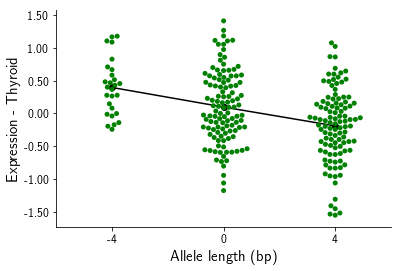

In [68]:
chrom = "chr19"
start = 19424949
end = 19424949
gene = "ENSG00000213996.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TM6SF2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# MAN2A1

WholeBlood 2.3903926611045725e-06 -0.26802279948460983


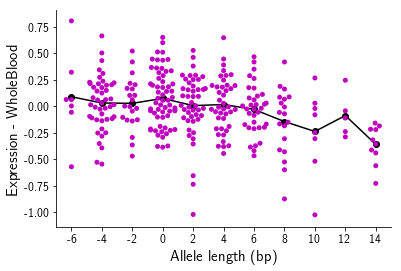

In [69]:
chrom = "chr5"
start = 109038017
end = 109038017
gene = "ENSG00000112893.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MAN2A1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Mucosa 0.0005041773665341903 0.22287076552713925


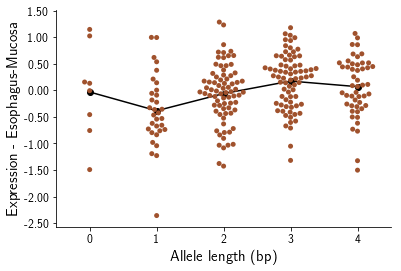

In [70]:
#APOC1

chrom = "chr19"
start = 45413225
end = 45413225
gene = "ENSG00000130208.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_APOC1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Adipose-Visceral 0.0005664761352715662 0.27553288792928354


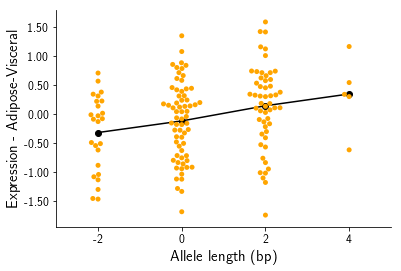

In [71]:
#HBG1

chrom = "chr11"
start = 5297399
end = 5297399
gene = "ENSG00000213934.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_HBG1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 9.591233185368318e-20 -0.5275656850145851
Lung 4.761158926955988e-09 -0.35898343539479444
Cells-Transformedfibroblasts 0.006490225487393729 -0.1830025440040342
Adipose-Subcutaneous 1.0007243494368985e-07 -0.3200746668595709
Skin-SunExposed 2.614712722495242e-22 -0.5289665827238854
Artery-Aorta 8.318084904072354e-16 -0.5479029899281787
Heart-LeftVentricle 0.0016422232031587645 -0.2251650722709184


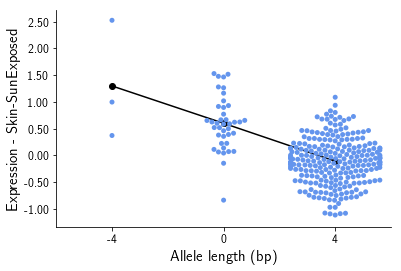

In [72]:
#ZNF436

chrom = "chr1"
start = 23692212
end = 23692212
gene = "ENSG00000125945.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ZNF436.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 1.2186419549159638e-05 -0.33424993754550736
Esophagus-Muscularis 2.6310167345876234e-06 -0.3474762084440401
Thyroid 6.498254123499425e-09 -0.3879253137139195
Lung 0.0017066669270210347 -0.21032607760093425
Esophagus-Mucosa 0.0040653410021728046 -0.1979496621875428
Adipose-Visceral 0.002630264996629791 -0.2392445577635205
Cells-Transformedfibroblasts 0.0013897811746474273 -0.2339830183220153
Muscle-Skeletal 0.006861589485649796 -0.16151469630916399
Adipose-Subcutaneous 5.074939380132081e-08 -0.3610875206251655
Skin-SunExposed 7.462282163477427e-12 -0.4209219688043211
WholeBlood 2.632897624030763e-17 -0.4791570980366721
Artery-Tibial 5.496120557543661e-14 -0.4765369182332157
Artery-Aorta 1.6878603561007018e-12 -0.5193086805797562
Nerve-Tibial 7.1237405585870776e-09 -0.3869759765416348


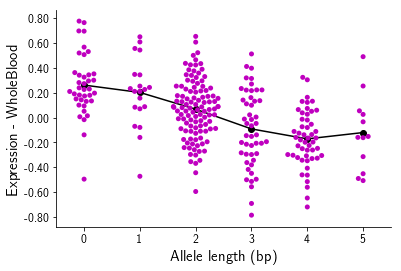

In [73]:
#TUFM

chrom = "chr16"
start = 28871190
end = 28871190
gene = "ENSG00000178952.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TUFM.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 8.152849409770303e-05 -0.3027169160103903
Esophagus-Muscularis 0.0033524820936420984 -0.22121475135900096
Esophagus-Mucosa 0.00011230330961112207 -0.26399230592268824
Cells-Transformedfibroblasts 0.004482785956051778 -0.2086281500894373
Skin-SunExposed 0.002924395754018338 -0.19011951006629105
Artery-Aorta 0.0008035633906115128 -0.2615644764108589


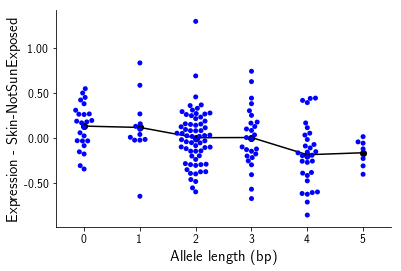

In [74]:
#NFATC2IP

chrom = "chr16"
start = 28871190
end = 28871190
gene = "ENSG00000176953.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NFATC2IP.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Lung 0.008680879413369348 -0.16308292891527135
Cells-Transformedfibroblasts 0.0014341920445199064 -0.21221878832388388
Heart-LeftVentricle 0.002517980136577575 -0.2141103451178916


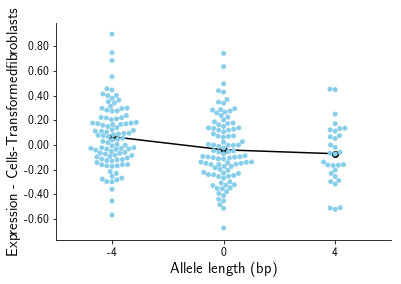

In [75]:
#PIEZO1

chrom = "chr16"
start = 88849253
end = 88849253
gene = "ENSG00000103335.15"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PIEZO1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Muscularis 2.03947334710571e-06 -0.3194941168722941
Thyroid 1.4701928500417606e-12 -0.4234194201283626
Lung 1.3813139391191794e-05 -0.2680010130056242
Brain-Cerebellum 4.392877712023655e-07 -0.4673898831848576
Adipose-Visceral 0.00035041719421017247 -0.25602359990596785
Cells-Transformedfibroblasts 8.636195228951847e-09 -0.37506092166130217
Muscle-Skeletal 7.73622951928193e-15 -0.40479977429744496
Adipose-Subcutaneous 4.002198572713174e-09 -0.3502722356937122
Artery-Tibial 2.568355131531763e-07 -0.30629447570559964
Brain-Caudate 9.30768047325275e-07 -0.4554669127564472
Artery-Aorta 0.007824247920340808 -0.19240832900567645
Heart-LeftVentricle 2.754304783568861e-06 -0.3276847776115308
Nerve-Tibial 7.721142168453876e-12 -0.406359751869594


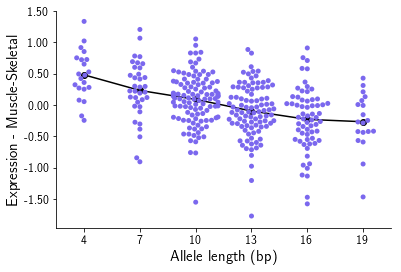

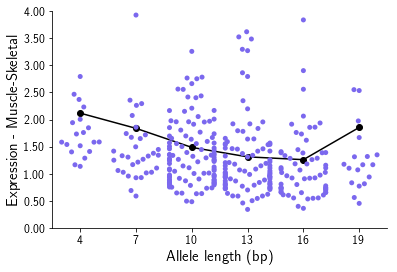

In [76]:
# DHRS1

chrom = "chr14"
start = 24769850
end = 24769850
gene = "ENSG00000157379.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DHRS1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=4)

Skin-NotSunExposed 4.813046776449265e-13 -0.4780326254975906
Esophagus-Muscularis 1.1086504724198415e-07 -0.3587461127376195
Thyroid 2.7053667758367393e-17 -0.4958818154954583
Lung 6.766590614423644e-07 -0.30572892628415466
Esophagus-Mucosa 1.2754647396001485e-07 -0.3271440169241276
Brain-Cerebellum 0.0027193103238491645 -0.2910838905785966
Adipose-Visceral 0.001871652996285455 -0.2259827359572863
Cells-Transformedfibroblasts 8.582729384291193e-08 -0.3529387170654306
Muscle-Skeletal 1.908349802978992e-06 -0.25755707461049265
Adipose-Subcutaneous 3.3713655680296893e-11 -0.3947017032175636
Skin-SunExposed 2.84225490615712e-14 -0.4262199980222597
WholeBlood 0.0065145221398126155 -0.1501755902253818
Artery-Tibial 6.669784258708792e-10 -0.3676239109212656
Brain-Caudate 1.8736958725950657e-05 -0.4044805382384575
Artery-Aorta 0.00044474942474980486 -0.254961951866369
Heart-LeftVentricle 0.00025621445450589554 -0.2609639995108606
Nerve-Tibial 7.993075521832815e-15 -0.4586200309370938


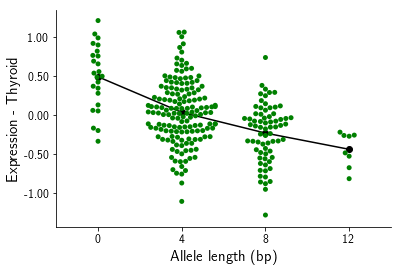

In [77]:
# ZFP69

chrom = "chr1"
start = 40942699
end = 40942699
gene = "ENSG00000187815.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ZFP69.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 2.9591965955922334e-05 0.29288154735878474
Esophagus-Muscularis 7.201771383093742e-08 0.3670183435544172
Thyroid 8.619720571080112e-17 0.4966707062659179
Lung 0.001121358609264566 0.20779659651505825
Esophagus-Mucosa 2.4308247447286004e-06 0.2988553142920136
Brain-Cerebellum 6.85330450639231e-16 0.6858761576370914
Adipose-Visceral 0.004796040434670794 0.20934584236453696
Cells-Transformedfibroblasts 1.106796940242573e-05 0.29814939129561385
Adipose-Subcutaneous 3.515194043029888e-08 0.3380537505406529
Skin-SunExposed 1.1188177363768352e-06 0.2861793735162902
Artery-Tibial 4.860906857146372e-07 0.3060106920590264
Brain-Caudate 0.0032609795761696504 0.28455594161221304
Artery-Aorta 0.0018139925813891555 0.23157801234414802
Heart-LeftVentricle 0.000977557162122008 0.23856147772967426
Nerve-Tibial 1.866112607804761e-22 0.5646681784076799


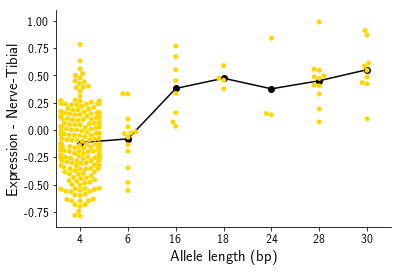

In [78]:
# SAP25

chrom = "chr7"
start = 100172242
end = 100172242
gene = "ENSG00000205307.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SAP25.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Muscle-Skeletal 0.00019212758805159776 -0.22186535360104426
Heart-LeftVentricle 3.486302280583963e-05 -0.3172487114356653


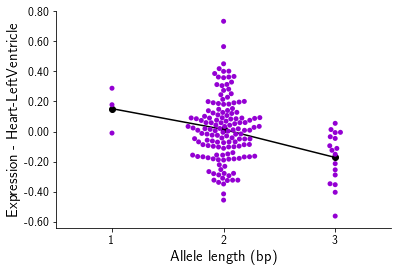

In [79]:
# DPP8

chrom = "chr15"
start = 65814608
end = 65814608
gene = "ENSG00000074603.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DPP8.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 4.59661568313741e-06 0.31384444171648457
Esophagus-Muscularis 5.9487247345334205e-05 0.2733853817465279
Thyroid 0.006316015670752465 0.16895849028685472
Lung 1.832318998070736e-05 0.26479594319421024
Esophagus-Mucosa 0.00021127994485569532 0.2313766835166579
Adipose-Visceral 0.0035936360226743484 0.2102642939439566
Muscle-Skeletal 0.00014834544595361508 0.2046235946800476
Adipose-Subcutaneous 1.171879084979283e-05 0.26514741718752605
Skin-SunExposed 0.0070843362826449405 0.15648136274016067
WholeBlood 1.2347701629927942e-05 0.23771777165574426
Artery-Tibial 4.210360290166058e-06 0.2743460266109994
Heart-LeftVentricle 0.004776108507305778 0.2002755612279616
Nerve-Tibial 2.1648275732266304e-06 0.2894423043435592


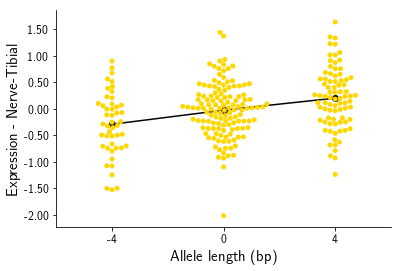

In [80]:
# ZNF468

chrom = "chr19"
start = 53364258
end = 53364258
gene = "ENSG00000204604.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ZNF468.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 2.5781552565243584e-09 -0.4092921350705594
Esophagus-Muscularis 1.966845542407964e-13 -0.4839444354335688
Thyroid 4.212121374111165e-21 -0.5520274703873155
Lung 9.416881103925935e-28 -0.6221621850385857
Esophagus-Mucosa 1.7779697408289858e-22 -0.5735126027263505
Brain-Cerebellum 0.00010017613466999424 -0.3738745749063188
Adipose-Visceral 9.81501476128822e-13 -0.4932480508706427
Cells-Transformedfibroblasts 2.1456341850723983e-19 -0.5621592607204462
Muscle-Skeletal 2.6383286168220136e-12 -0.3730934350100011
Adipose-Subcutaneous 1.77720211373184e-30 -0.6374130184143203
Skin-SunExposed 5.014910538727717e-18 -0.4802918498510179
WholeBlood 1.1998936789441095e-33 -0.6088913211512617
Artery-Tibial 7.081179998510427e-24 -0.5680901618826645
Artery-Aorta 1.3358384091250651e-12 -0.4942351605475319
Heart-LeftVentricle 9.953551065227638e-07 -0.34793433313164
Nerve-Tibial 1.3791202289775844e-09 -0.3712179783225184


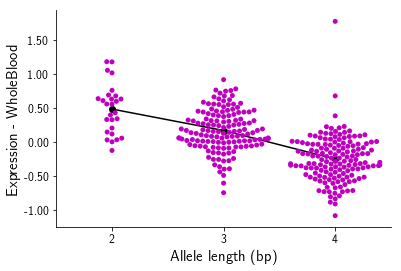

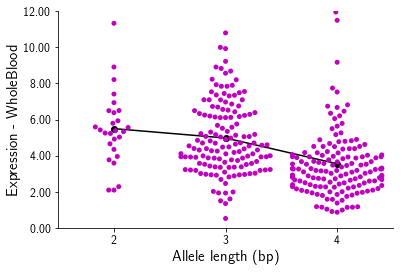

In [81]:
# GRHPR

chrom = "chr9"
start = 37422521
end = 37422521
gene = "ENSG00000137106.13"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GRHPR.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=12)

Esophagus-Muscularis 8.720477043620888e-08 0.3782273355877455
Muscle-Skeletal 6.87330332802269e-06 0.250357845874982
Heart-LeftVentricle 0.0012934335112878756 0.23932847222546005


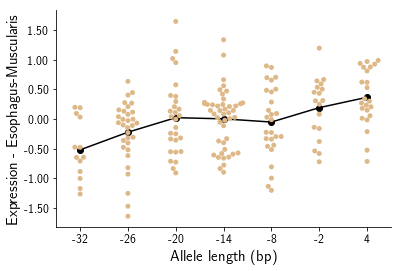

In [82]:
# ANKEF1

chrom = "chr20"
start = 10015524
end = 10015524
gene = "ENSG00000132623.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ANKEF1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Adipose-Subcutaneous 1.601107049641929e-05 0.2785240483018483
Skin-SunExposed 0.003254711172096943 0.1846872017012986
Artery-Aorta 0.001277505888889704 0.25018789724326995


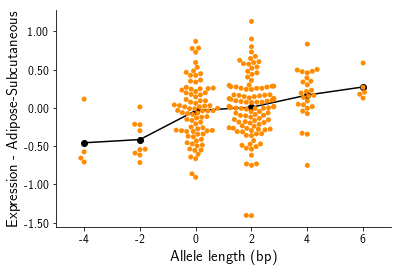

In [83]:
# CCDC80

chrom = "chr3"
start = 112369217
end = 112369217
gene = "ENSG00000091986.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CCDC80.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 0.003606863505820236 0.1838052496260193
Brain-Cerebellum 0.0021563041831568824 0.2961856914664633
Adipose-Visceral 0.008937355329241883 0.19276981058826664
Muscle-Skeletal 7.049137391894606e-07 0.2682230695917362
Adipose-Subcutaneous 2.1064174959514182e-06 0.2897662706970658


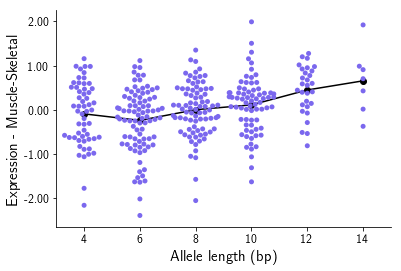

In [84]:
# PLA2G5

chrom = "chr1"
start = 20350885
end = 20350885
gene = "ENSG00000127472.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PLA2G5.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Adipose-Visceral 0.009673163766592871 -0.2072332787422281
Cells-Transformedfibroblasts 7.224171261714171e-07 -0.3613307116042384
WholeBlood 0.0011233111456121594 -0.1968593273517525
Nerve-Tibial 0.0047974631390953395 -0.1939275568671137


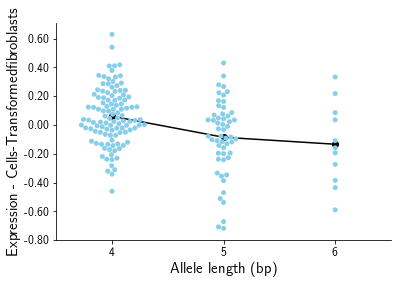

In [85]:
# DHX16

chrom = "chr6"
start = 30642305
end = 30642305
gene = "ENSG00000204560.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DHX16.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 5.453816331709665e-10 0.4180125153008779
Skin-SunExposed 1.0382227498965788e-06 0.28218211144810645


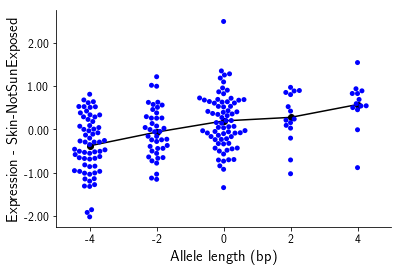

In [86]:
# VGF

chrom = "chr7"
start = 100812579
end = 100812579
gene = "ENSG00000128564.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VGF.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 3.868449601836074e-06 0.3161780033735174
Thyroid 1.223015704504829e-12 0.4240418918511829
Lung 1.0138368711431502e-06 0.3005268547951555
Esophagus-Mucosa 0.009779934653880136 0.16215082316092566
Brain-Cerebellum 1.854292912557379e-05 0.4083341267209747
Cells-Transformedfibroblasts 1.0943786310934016e-05 0.2897728795650029
Muscle-Skeletal 3.6112782358358614e-13 0.3822688037772831
Adipose-Subcutaneous 7.567082037172161e-10 0.3665182753629425
Skin-SunExposed 9.197576702743916e-05 0.2264664039982317
WholeBlood 0.004489278100848049 0.15558713796261234
Artery-Tibial 5.771394121740094e-09 0.3432486138146259
Brain-Caudate 0.001835648773035287 0.3005866236025509
Artery-Aorta 2.222279430078348e-13 0.5017295912854955
Heart-LeftVentricle 6.171611925788504e-07 0.34889934780891824
Nerve-Tibial 1.3447177253073078e-10 0.3846983398544555


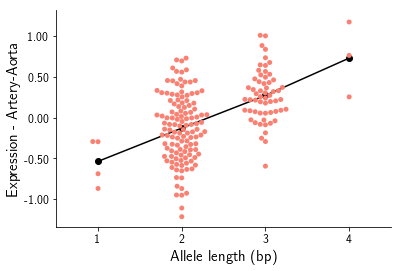

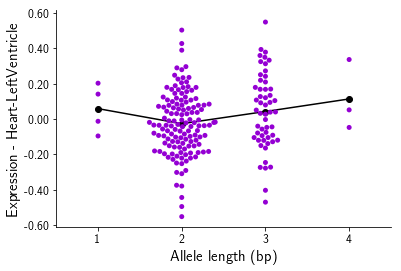

In [87]:
# PHLPP2

chrom = "chr16"
start = 71761882
end = 71761882
gene = "ENSG00000040199.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PHLPP2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

# AP1G1

chrom = "chr16"
start = 71761882
end = 71761882
gene = "ENSG00000166747.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_AP1G1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 0.00046306640064918135 -0.24592416018982616
Esophagus-Muscularis 4.0162185895249225e-10 -0.4199907901644329
Thyroid 3.319598423380218e-16 -0.4840229103973897
Lung 2.8267960073600256e-06 -0.2934726422847128
Esophagus-Mucosa 6.4600214698429706e-12 -0.4236657841553567
Adipose-Visceral 8.790858034108319e-05 -0.2873212864069519
Cells-Transformedfibroblasts 7.460277771342235e-36 -0.7203705178576623
Adipose-Subcutaneous 3.025716017258853e-09 -0.35924447605835824
Skin-SunExposed 3.994564405517115e-08 -0.3181709991132179
Artery-Tibial 6.867575024791292e-17 -0.48373139004944
Brain-Caudate 3.4420370213017886e-08 -0.5047576913538152
Artery-Aorta 7.145302689412754e-12 -0.4798922847766605
Heart-LeftVentricle 7.487441054869326e-05 -0.2811203159044727


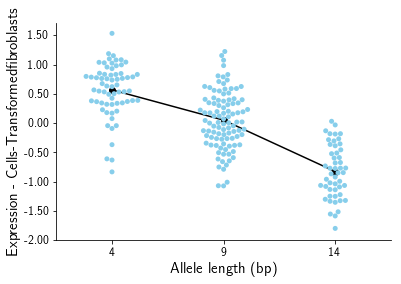

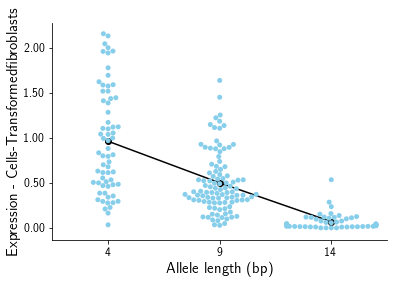

In [88]:
# MCOLN2

chrom = "chr1"
start = 85462853
end = 85462853
gene = "ENSG00000153898.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MCOLN2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=None)

Thyroid 1.009845039576925e-19 0.5527493055572664
Lung 2.6013469041137232e-23 0.5928053509205199
Esophagus-Mucosa 7.176608924882991e-13 0.4600794221190123
Adipose-Subcutaneous 3.755559605168692e-06 0.2940348512926712


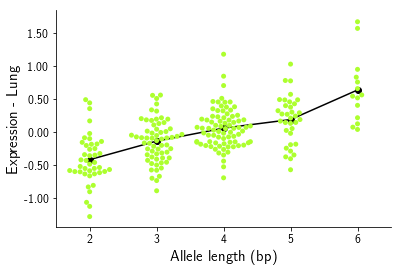

In [89]:
# SMPDL3B

chrom = "chr1"
start = 28250549
end = 28250549
gene = "ENSG00000130768.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SMPDL3B.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 1.2979714458185298e-06 0.3592738400294431
Esophagus-Muscularis 2.2287455692036377e-12 0.4899272501783633
Thyroid 8.399984298706792e-14 0.4772748447601611
Lung 2.5429475723997366e-10 0.41244284723807023
Esophagus-Mucosa 5.2615363100760205e-19 0.5603246790804618
Adipose-Visceral 0.0013325311165330454 0.25312415929458265
Cells-Transformedfibroblasts 2.953081731546198e-20 0.6102260805217132
Muscle-Skeletal 7.80672654162065e-09 0.3358086908251172
Skin-SunExposed 1.0555418182610436e-10 0.3990485776646467
Artery-Tibial 4.358802756393254e-11 0.413650409121336
Brain-Caudate 0.0002163622871292068 0.3931180126909741
Artery-Aorta 2.174862832648295e-07 0.4043585554739731
Heart-LeftVentricle 2.9760534876980814e-10 0.4629951566770519
Nerve-Tibial 1.1231605862384572e-11 0.4308484539127939


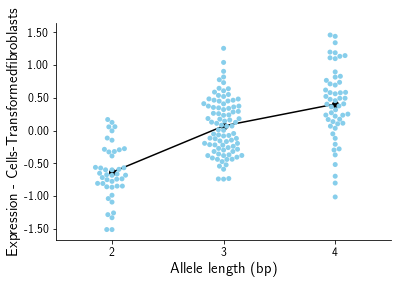

In [90]:
# LRRIQ3

chrom = "chr1"
start = 74679220
end = 74679220
gene = "ENSG00000162620.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_LRRIQ3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 3.308542984344682e-14 -0.5287031013364281
Esophagus-Muscularis 1.0832039427646276e-27 -0.6946449978300216
Thyroid 4.0182583200490494e-11 -0.4235828968335378
Lung 7.91256032668289e-27 -0.6330838062216425
Esophagus-Mucosa 4.024679812948991e-16 -0.5153754486706789
Brain-Cerebellum 7.244082479329144e-09 -0.5484953849521483
Adipose-Visceral 8.991281895590322e-20 -0.639448483392244
Cells-Transformedfibroblasts 3.724821170282508e-18 -0.5743485246128718
Muscle-Skeletal 8.892184739983911e-24 -0.5420544317923294
Adipose-Subcutaneous 7.242508771350368e-23 -0.5879101645921129
Skin-SunExposed 1.2031155812472684e-19 -0.5281208966484936
WholeBlood 4.089366561901029e-09 -0.339428952489101
Artery-Tibial 1.5495175721244596e-32 -0.6702498329350856
Brain-Caudate 2.481636213001616e-05 -0.4223021017301741
Artery-Aorta 3.76124419418728e-14 -0.546458300929707
Heart-LeftVentricle 1.2243825182983367e-19 -0.61848011295512
Nerve-Tibial 1.2806428827251465e-19 -0.5494354694947455


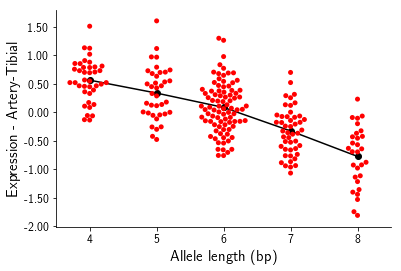

In [91]:
# C15orf57

chrom = "chr15"
start = 40871658
end = 40871658
gene = "ENSG00000128891.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_C15orf57.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 2.4666679486867238e-05 -0.292080778484166
Esophagus-Muscularis 0.0012754823167371654 -0.2213878106379154
Thyroid 3.923463125847364e-26 -0.5971931214663146
Lung 2.0696048117328074e-09 -0.3640801777527147
Cells-Transformedfibroblasts 2.6362548883990813e-05 -0.2799037282482375
Adipose-Subcutaneous 0.00047743776916520976 -0.21351454662639385
Skin-SunExposed 7.551374979291812e-10 -0.350175649246051
Brain-Caudate 3.805155887632545e-06 -0.4299468959773235
Nerve-Tibial 2.529604755072032e-17 -0.4954343235881981


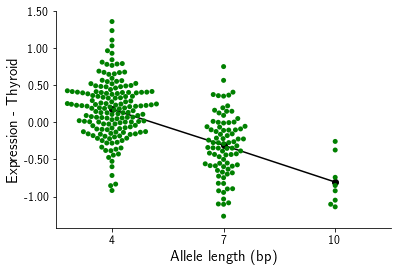

In [92]:
# SHISA4

chrom = "chr1"
start = 201841735
end = 201841735
gene = "ENSG00000198892.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SHISA4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Mucosa 3.522312626743585e-17 -0.5003361428957407


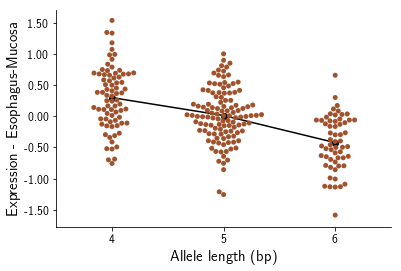

In [93]:
# C12orf36

chrom = "chr12"
start = 13542438
end = 13542438
gene = "ENSG00000180861.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_C12orf36.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 0.00023885365252888617 0.23038061184799885
Brain-Cerebellum 6.751087579808952e-08 0.5037942556387869
Adipose-Subcutaneous 0.0017049369767823145 0.1936569100064792


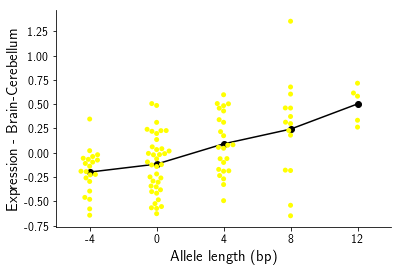

In [94]:
# CASD1

chrom = "chr7"
start = 94121240
end = 94121240
gene = "ENSG00000127995.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CASD1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 1.3643796708036305e-05 -0.30078090993304524
Esophagus-Muscularis 2.1691749119747184e-15 -0.5103215441576949
Thyroid 1.606480400468217e-07 -0.3197925870383975
Lung 3.2446478027999714e-13 -0.4384514162536832
Esophagus-Mucosa 1.7052928778827773e-10 -0.39119851117920856
Brain-Cerebellum 2.6809633529322675e-05 -0.4029597553409586
Adipose-Visceral 2.8584835032343018e-05 -0.30011947227056746
Cells-Transformedfibroblasts 3.86727000708658e-06 -0.30630101969680656
Muscle-Skeletal 2.6436251989197183e-14 -0.4005813891271629
Adipose-Subcutaneous 2.883642746663963e-13 -0.4286154982723467
Skin-SunExposed 1.4624173604548535e-08 -0.3250400385835075
Artery-Tibial 1.8308976636689518e-14 -0.44463849975722997
Brain-Caudate 9.163436112726101e-07 -0.4576869714650183
Artery-Aorta 3.8300749547518414e-08 -0.3878017040359741
Heart-LeftVentricle 5.7460271299324917e-08 -0.3784427643668548
Nerve-Tibial 1.6037860904203205e-11 -0.4013429975163181


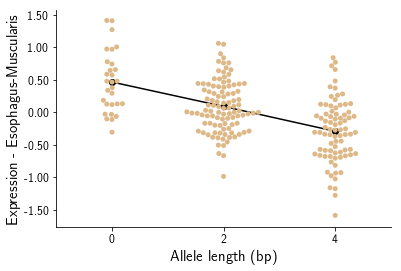

In [95]:
# ZSCAN23

chrom = "chr6"
start = 28419904
end = 28419904
gene = "ENSG00000187987.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ZSCAN23.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 0.009330368741115234 0.18669547947515555
Esophagus-Muscularis 3.907622427819013e-09 0.407902308628927
Thyroid 1.9339393027324515e-07 0.3303446238978249
Esophagus-Mucosa 0.006128526018759946 0.1810085968362164
Brain-Cerebellum 9.664895836752172e-05 0.3873479265197798
Adipose-Visceral 0.002678676012351771 0.2256421087802423
Cells-Transformedfibroblasts 5.607494347637491e-15 0.5224018859013229
Muscle-Skeletal 0.0012787817572629302 0.1836004727066215
Adipose-Subcutaneous 4.618698262219272e-06 0.2868148066851537
Skin-SunExposed 0.0008660144037975196 0.20304825861166406
Artery-Aorta 1.0291329787875413e-05 0.33398572018131434
Nerve-Tibial 2.032466356164923e-09 0.3740212841733826


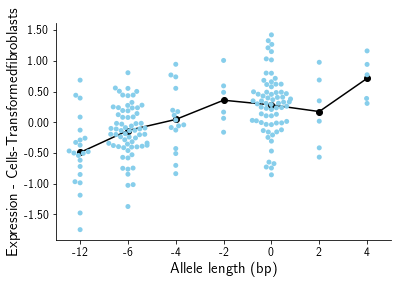

In [96]:
# TRPV2

chrom = "chr17"
start = 16316604
end = 16316604
gene = "ENSG00000187688.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TRPV2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 9.72038877614616e-08 -0.359435365553164
Esophagus-Muscularis 8.751197944628841e-21 -0.5840864814949891
Thyroid 2.389623549106108e-16 -0.4794188894143448
Lung 1.9292580336779925e-25 -0.5876260902316559
Esophagus-Mucosa 5.209087497589217e-23 -0.5679584178073579
Adipose-Visceral 1.4029558364959473e-25 -0.6619823258789694
Cells-Transformedfibroblasts 5.154344208687343e-15 -0.492294529952004
Muscle-Skeletal 1.8895995452415645e-05 -0.2290595694855907
Adipose-Subcutaneous 2.8742005041241682e-37 -0.6750558784933578
Skin-SunExposed 4.193932977539953e-13 -0.4048815420916555
WholeBlood 3.736332330531095e-28 -0.5530733316258533
Artery-Tibial 4.0453401422037685e-12 -0.4029399391305711
Artery-Aorta 1.025990294131638e-13 -0.5042851815479708
Heart-LeftVentricle 9.89031315319326e-14 -0.4977977839058296
Nerve-Tibial 9.056506041375126e-32 -0.6405039250575718


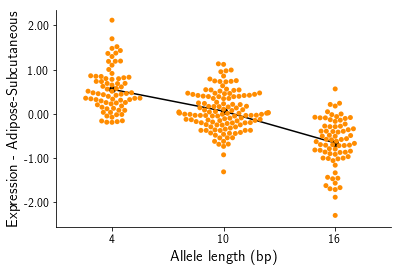

In [97]:
# ZC3H3

chrom = "chr8"
start = 144630218
end = 144630218
gene = "ENSG00000014164.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ZC3H3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 8.623155639914017e-22 -0.6078215638261073
Esophagus-Mucosa 1.2520101846941221e-15 -0.4815749380576427
Brain-Cerebellum 7.999690645732264e-06 -0.4222896979557622
Cells-Transformedfibroblasts 1.8101480009104733e-08 -0.3738324606285523
Muscle-Skeletal 7.992694048600392e-06 -0.2426788064966038
Adipose-Subcutaneous 1.4265618259110602e-08 -0.3419774403503389
Skin-SunExposed 9.340013464078786e-32 -0.6182291041184622
Artery-Tibial 1.0094419799221028e-11 -0.4021556369142728
Artery-Aorta 1.1802908872158884e-06 -0.3474525545670976
Nerve-Tibial 2.1686988061012862e-14 -0.4551094316025683


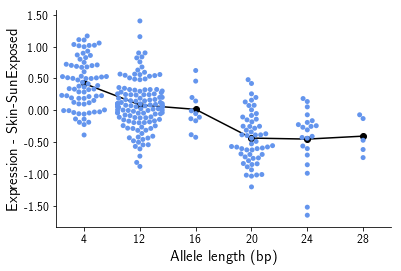

In [98]:
# FBXO27

chrom = "chr19"
start = 39540621
end = 39540621
gene = "ENSG00000161243.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FBXO27.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Muscularis 6.49401995393167e-08 -0.37980730177992056
Thyroid 0.00040554262355265385 -0.2293244640667409
Adipose-Visceral 0.0003673915127886401 -0.2685852435591929
Muscle-Skeletal 0.0012862901903120045 -0.18350642615508567
Adipose-Subcutaneous 0.004729248851479522 -0.18177519068140013
Heart-LeftVentricle 7.90087475634456e-07 -0.3620736825689129
Nerve-Tibial 0.007886079433182695 -0.17366921938713106


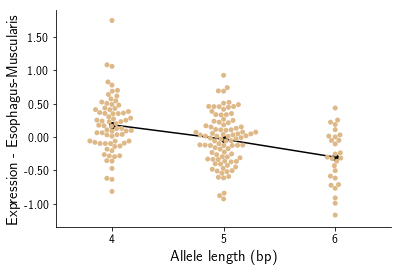

In [99]:
# AGRN

chrom = "chr1"
start = 952495
end = 952495
gene = "ENSG00000188157.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_AGRN.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 0.0014286599294035158 -0.22291644425821264
Esophagus-Muscularis 9.32795660699321e-06 -0.3047736412342605
Lung 0.005806938484347625 -0.1740013083535368
Esophagus-Mucosa 6.754645139268008e-06 -0.2825602939918439
Adipose-Visceral 2.022625843356501e-05 -0.30622796730415514
Cells-Transformedfibroblasts 3.673530514929749e-11 -0.4305752215452108
Muscle-Skeletal 0.006627183806328007 -0.14941144939713022
Adipose-Subcutaneous 3.81880181593499e-05 -0.2543842395563066
Skin-SunExposed 4.475122371688006e-09 -0.3374967482249829
Artery-Tibial 1.8861538258380104e-14 -0.4482146928991385
Brain-Caudate 8.659737426976947e-05 -0.3770060760193044
Artery-Aorta 1.548821993641071e-07 -0.3732272066208958
Nerve-Tibial 0.002407212886796109 -0.18962295613510224


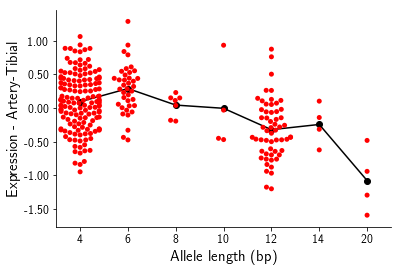

In [100]:
# IFT46

chrom = "chr11"
start = 118446127
end = 118446127
gene = "ENSG00000118096.3"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IFT46.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Muscle-Skeletal 2.14576087936715e-06 -0.2764503228017628
Artery-Aorta 1.4680376847732058e-06 -0.37331806343797774


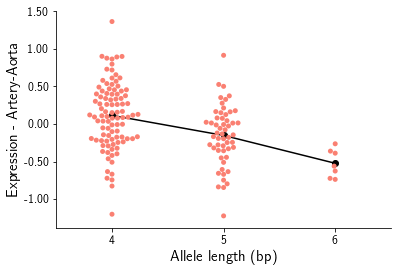

In [101]:
# # PUS3

chrom = "chr11"
start = 125777503
end = 125777503
gene = "ENSG00000110060.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PUS3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 0.00880564189589495 0.18208948853710885
Lung 0.005660342875317432 0.17247344517232674
Esophagus-Mucosa 1.9159308992071986e-09 0.3675064035002025
Skin-SunExposed 2.068410687104655e-10 0.3597476757943334


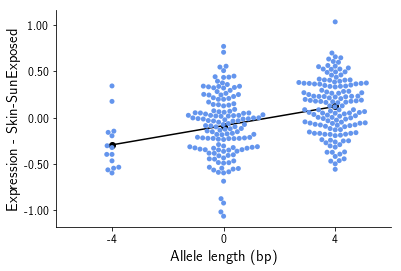

In [102]:
# # VAMP8

chrom = "chr2"
start = 85786843
end = 85786843
gene = "ENSG00000118640.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VAMP8.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 0.002795439594548909 -0.2197789654570312
Muscle-Skeletal 0.009372212116885143 0.1495352774090566
Artery-Tibial 6.2658621719194e-05 0.2543670683645545
Heart-LeftVentricle 1.8639747121679427e-06 0.3504106774185396


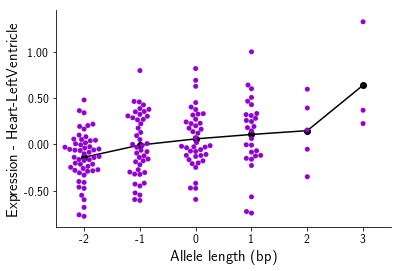

In [103]:
# # EOGT

chrom = "chr3"
start = 69067514
end = 69067514
gene = "ENSG00000163378.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_EOGT.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 0.00637934660382979 -0.17106513263711096
Esophagus-Mucosa 2.456426938795628e-08 -0.3489367276096593
WholeBlood 0.0020243946126685783 -0.17061572110460216
Nerve-Tibial 0.0005468310178085247 -0.21666900955821985


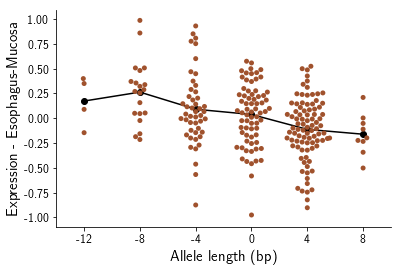

In [104]:
# # SLC35C1

chrom = "chr11"
start = 45822502
end = 45822502
gene = "ENSG00000181830.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SLC35C1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 0.00615700450135806 0.1898099932766032
Esophagus-Muscularis 0.0017934640424324265 0.2147475259456932
Thyroid 2.901942979547887e-06 0.28701991917977737
Lung 1.264814334618162e-06 0.2979624064653153
Esophagus-Mucosa 0.0021298285099840475 0.19339103504565852
Brain-Cerebellum 4.208230518948508e-05 0.385090823353798
Skin-SunExposed 0.002342231871456736 0.17682480855183627
Brain-Caudate 0.0008012725783733749 0.3193073533539613
Artery-Aorta 6.528031189023453e-05 0.28623646523248425
Nerve-Tibial 1.5912323967634694e-05 0.2641499042736222


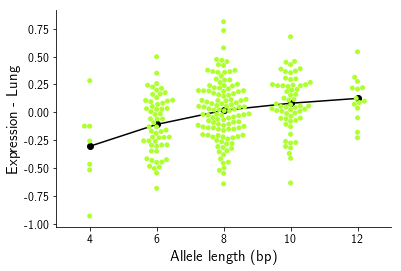

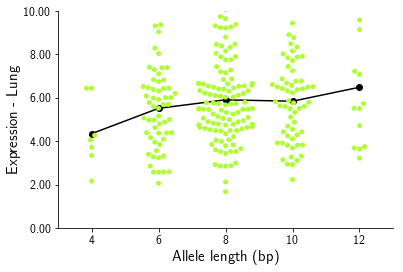

In [105]:
# # ACBD4

chrom = "chr17"
start = 43205137
end = 43205137
gene = "ENSG00000181513.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ACBD4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=10)

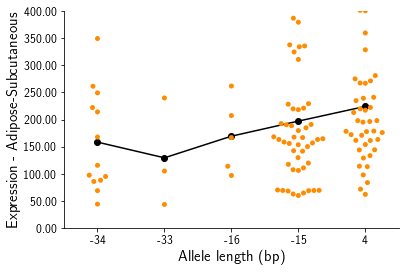

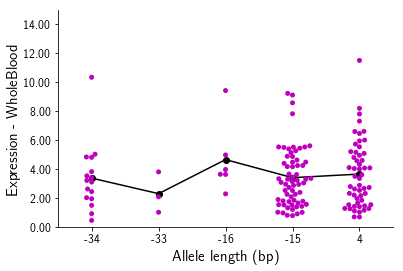

In [106]:
# TOMM40
COLORS["Liver"] = "gray"
chrom = "chr19"
start = 45403049
end = 45403049

gene = "ENSG00000130203.5" # APOE
best_tissue = "Adipose-Subcutaneous"
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=400)

gene = "ENSG00000130204.8" # TOMM40
best_tissue = "WholeBlood"
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS, maxy=15)

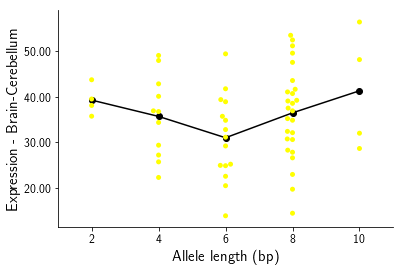

In [107]:
# SNCA

chrom = "chr4"
start = 90767173
end = 90767173

gene = "ENSG00000145335.11" # SNCA
best_tissue = "Brain-Cerebellum"
PlotRawESTR(gene, best_tissue, chrom, start, end, COLORS)


Esophagus-Mucosa 2.190138925373813e-06 0.3178563213940841


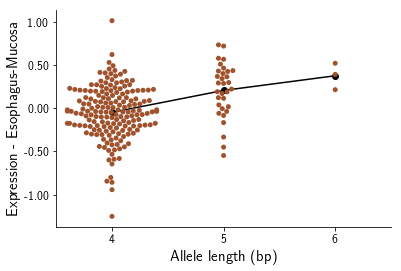

In [108]:
# FAM134A

chrom = "chr2"
start = 220082366
end = 220082366
gene = "ENSG00000144567.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FAM134A.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Muscularis 0.001457208805355738 -0.2349038824058016
Thyroid 4.884646083845372e-06 -0.3059285413898763
Lung 0.00015564657362137526 -0.2545499032652899
Esophagus-Mucosa 0.00016090191759215232 -0.25343820104783565
Cells-Transformedfibroblasts 0.005021232291349857 -0.2054640074291837
Adipose-Subcutaneous 1.0188611558355956e-05 -0.29012120345330683
Skin-SunExposed 7.364401922260456e-05 -0.2490082007237601
WholeBlood 0.0019313530519238253 -0.18387735942412228
Brain-Caudate 9.202385057302056e-05 -0.4068666081313226
Nerve-Tibial 4.620328335857167e-06 -0.30132147030984635


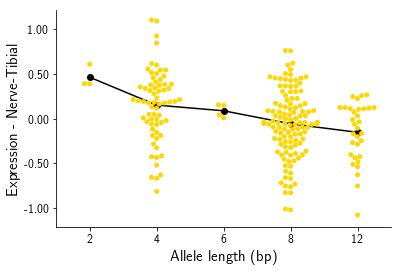

In [109]:
# TMEM81

chrom = "chr1"
start = 205076171
end = 205076171
gene = "ENSG00000174529.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TMEM81.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 0.00012245915218456348 0.2516632118945069


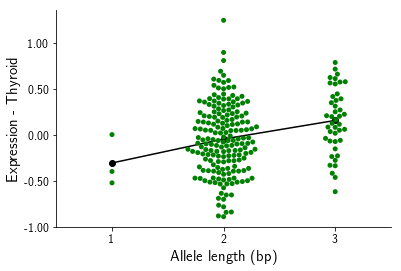

In [111]:
# CCDC126

chrom = "chr7"
start = 23615272
end = 23615272
gene = "ENSG00000169193.7"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CCDC126.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 6.454287956861424e-09 -0.40554642823427134
Esophagus-Muscularis 1.003778695355493e-11 -0.4582539897595808
Lung 0.004659027132366845 -0.18207825216731285
Esophagus-Mucosa 2.200256221916801e-06 -0.30129205563931805
Adipose-Visceral 3.889665426121252e-08 -0.3965829434665271
Cells-Transformedfibroblasts 4.067907678648584e-05 -0.2804901618216889
Muscle-Skeletal 0.0005647621305379383 -0.19111840761891075
Adipose-Subcutaneous 5.427888987524381e-10 -0.37751685764067855
Skin-SunExposed 3.150554516406345e-09 -0.34639860932014715
WholeBlood 2.3050147243679146e-07 -0.287349252514153
Artery-Tibial 1.0000054620837142e-08 -0.3485796810942659
Artery-Aorta 1.480878870602499e-07 -0.3795654954246657
Nerve-Tibial 9.291972072476893e-15 -0.4700181930617804


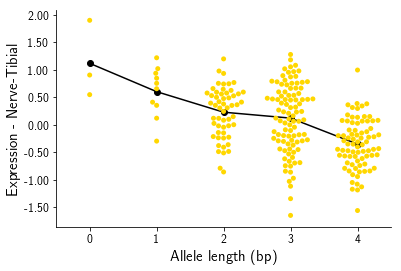

In [112]:
# SPIRE2

chrom = "chr16"
start = 89829656
end = 89829656
gene = "ENSG00000204991.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SPIRE2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Aorta 0.0004627387422402775 -0.26192537435701424
Brain-Caudate 0.002171434011080433 -0.3061413768408105
Nerve-Tibial 0.0075454863140149145 -0.17207141358156725
Brain-Cerebellum 4.6290061890640635e-05 -0.40324634930532144


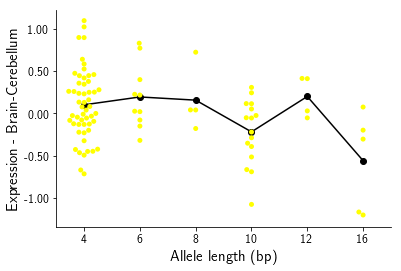

In [3]:
# VARS2

chrom = "chr6"
start = 30884231
end = 30884231
gene = "ENSG00000137411.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_VARS2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Muscularis 0.0006291682353298152 -0.2503965857319298


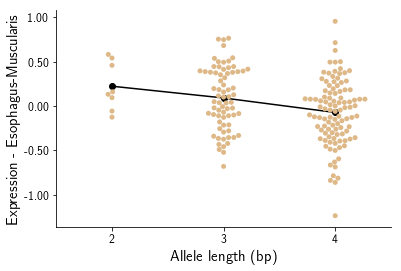

In [4]:
# UBAP2L

chrom = "chr1"
start = 154251259
end = 154251259
gene = "ENSG00000143569.14"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_UBAP2L.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Brain-Cerebellum 2.487857407150113e-05 0.4025977745325063


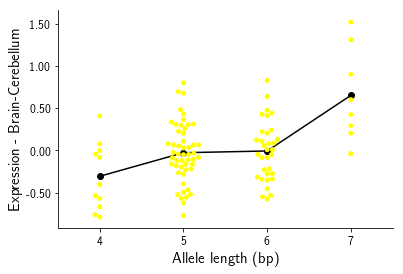

In [4]:
# PDCD11

chrom = "chr10"
start = 105191397
end = 105191397
gene = "ENSG00000148843.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PDCD11.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Nerve-Tibial 0.0004163355710975727 0.2454383801897453
Brain-Caudate 0.00034165163002753627 0.373229950033286


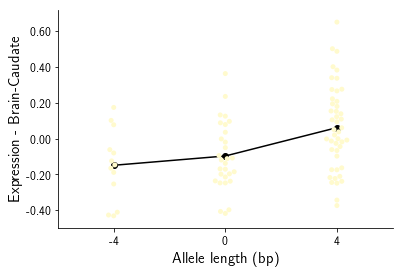

In [5]:
# CTNND1

chrom = "chr11"
start = 57522177
end = 57522177
gene = "ENSG00000198561.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CTNND1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 0.0009515512659231972 0.2243173414791238
Esophagus-Mucosa 4.776681316708794e-05 0.28134877301057953
Skin-NotSunExposed 1.117166077920359e-05 0.3317664202445045
Adipose-Subcutaneous 2.2509576144349126e-07 0.3397745080032321
Esophagus-Muscularis 0.0033594006429430692 0.2217991274700904
Lung 0.0024789675252884485 0.2072756030530664
Adipose-Visceral 0.002599060581135216 0.2426125678862244
Muscle-Skeletal 0.000626997856393629 0.2056934495344212
Skin-SunExposed 0.00012291648078191383 0.24536710412090704


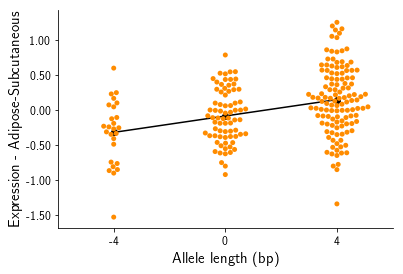

In [7]:
# MED19-2

chrom = "chr11"
start = 57522177
end = 57522177
gene = "ENSG00000156603.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MED19-2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Mucosa 0.0007745755580008482 0.21556691593219127
Esophagus-Muscularis 0.006723053555182402 0.18966442834953207
Muscle-Skeletal 3.5369941514292724e-05 0.2293670257057963
Skin-SunExposed 0.001241433676934034 0.1937611203339817


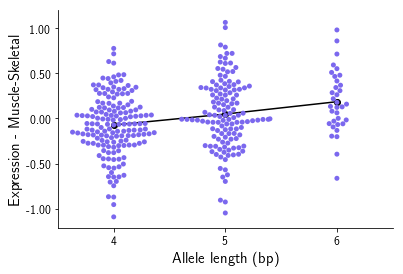

In [18]:
# GPATCH1

chrom = "chr19"
start = 33584177
end = 33584177
gene = "ENSG00000076650.2"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_GPATCH1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 1.5419586811659166e-16 -0.4725760224036886
Thyroid 7.238670235588854e-15 -0.457692087534521
Esophagus-Mucosa 4.9259607021360374e-08 -0.33587500181107593
Skin-NotSunExposed 0.0005017183659922455 -0.24035042328137904
Brain-Cerebellum 0.005760204956836657 -0.2677258530767845
Adipose-Subcutaneous 2.741665237070359e-17 -0.4851500583686241
Cells-Transformedfibroblasts 4.607451138895675e-11 -0.4215403877494564
WholeBlood 9.512633898001983e-13 -0.3790071840934999
Nerve-Tibial 8.579098817931125e-20 -0.5221003139410328
Heart-LeftVentricle 1.1741925780848309e-06 -0.33815376801684965
Esophagus-Muscularis 9.295346342188695e-10 -0.4055529190866098
Lung 3.596504255226953e-16 -0.47852603906356106
Adipose-Visceral 5.6817262930600995e-14 -0.5099688243369356
Artery-Aorta 4.036496954837052e-06 -0.3281374744949527
Muscle-Skeletal 3.013565704388695e-08 -0.29444649490931085
Skin-SunExposed 4.7746789668996465e-14 -0.4208307007931888


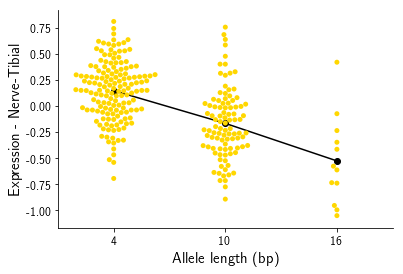

In [19]:
# SEC31B

chrom = "chr10"
start = 102302938
end = 102302938
gene = "ENSG00000075826.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SEC31B.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 0.009728330730541702 0.16728084795710566
Thyroid 0.0007149313710964487 0.22445298024123936
Esophagus-Mucosa 1.6494432711036218e-06 0.3200548230509632
Skin-NotSunExposed 0.003111184699450251 0.2241915712679801
Adipose-Subcutaneous 7.057153120473509e-06 0.2944386730935828
Cells-Transformedfibroblasts 6.979581209290764e-12 0.4655734384449001
WholeBlood 4.9662661502501156e-11 0.373476791549221
Nerve-Tibial 1.8909030148465725e-09 0.38852174533228
Esophagus-Muscularis 0.0004812648500481619 0.2568932205106469
Lung 0.0035557761594210593 0.1944356128962036
Adipose-Visceral 0.0031305087873807662 0.22938734888304999
Muscle-Skeletal 0.005492227384696207 0.16322682885082335


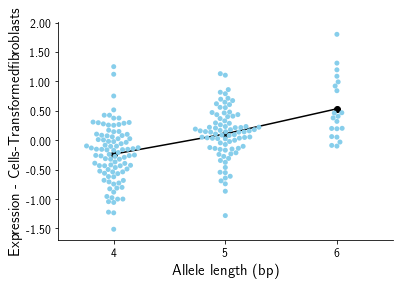

In [20]:
# SDCCAG8

chrom = "chr1"
start = 243390569
end = 243390569
gene = "ENSG00000054282.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SDCCAG8.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 7.298276580558769e-17 0.47859904752207705
Thyroid 0.0007263479326126152 0.2111091709806976
Esophagus-Mucosa 0.00013063039403793579 0.2415003788410765
Skin-NotSunExposed 0.0003917512337708645 0.2495548993279333
Adipose-Subcutaneous 1.663506514536913e-11 0.40105335928821934
Cells-Transformedfibroblasts 0.00022214875088890802 0.2464935672838674
Nerve-Tibial 0.00042887149847743234 0.2180874514211697
Heart-LeftVentricle 1.716796610438476e-05 0.30405569723711856
Esophagus-Muscularis 2.828648798771709e-09 0.3963830884481502
Lung 3.706359518819523e-10 0.3794764600491532
Adipose-Visceral 0.006418649317200324 0.20080105617929025
Artery-Aorta 9.570828116022249e-07 0.3502206079413485
Muscle-Skeletal 7.058180064923215e-10 0.3286448299438582
Skin-SunExposed 3.590760293721365e-08 0.3186685525364751


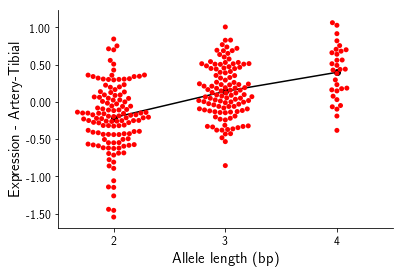

In [21]:
# THAP3

chrom = "chr1"
start = 6683566
end = 6683566
gene = "ENSG00000041988.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_THAP3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 1.593558093512983e-18 0.5013139195221571
Thyroid 6.759514553434175e-16 0.4762180764008182
Esophagus-Mucosa 1.096779944951686e-07 0.32750458268851984
Skin-NotSunExposed 1.1138284687329634e-06 0.3324687867156858
Brain-Cerebellum 1.5032191251856081e-10 0.5742772321597615
Adipose-Subcutaneous 1.1739925135596947e-16 0.4789138213431434
Cells-Transformedfibroblasts 9.4910265822523e-08 0.35029836817319754
Nerve-Tibial 7.964390454910789e-23 0.5613780768515136
Heart-LeftVentricle 4.365305205668062e-10 0.4299686557819399
Esophagus-Muscularis 2.492671696643171e-10 0.4188884295098795
Adipose-Visceral 0.00010161543148208924 0.2796551736187077
Artery-Aorta 3.8272077880489337e-07 0.3602007340281952
Muscle-Skeletal 1.8338848712079816e-10 0.33774470366532683
Skin-SunExposed 2.395910215914736e-14 0.42468713007528186
Brain-Caudate 0.0014746058778553385 0.3036611909925379


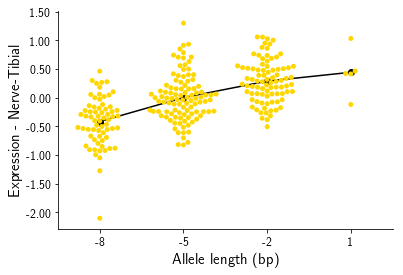

In [22]:
# PTPRCAP

chrom = "chr11"
start = 67238583
end = 67238583
gene = "ENSG00000213402.2"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PTPRCAP.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 3.713612481291245e-14 0.43696216176393693
Thyroid 8.39227971155422e-16 0.4715953863273238
Esophagus-Mucosa 5.646524856684369e-23 0.5694405574857725
Skin-NotSunExposed 1.3559285475782913e-15 0.5188640454977393
Brain-Cerebellum 6.062764251132292e-06 0.4217409677558091
Adipose-Subcutaneous 9.0517888154249e-12 0.4009140750687016
Cells-Transformedfibroblasts 3.232285096699332e-17 0.5263040982462134
WholeBlood 4.655714107414423e-06 0.2483338822545828
Nerve-Tibial 3.5543057267817114e-14 0.4454612433192048
Heart-LeftVentricle 6.118270481102758e-12 0.4666992490091124
Esophagus-Muscularis 3.95100273556856e-19 0.5641731554533811
Lung 1.2614303285292992e-14 0.4555790841180826
Adipose-Visceral 2.0241853651842217e-14 0.5189010262748583
Artery-Aorta 4.2809668687694845e-14 0.5144671451513971
Muscle-Skeletal 3.2006905722402256e-17 0.4355759917398673
Skin-SunExposed 1.724320739236444e-17 0.466952683546811
Brain-Caudate 0.0002452624196473365 0.3459376868181101


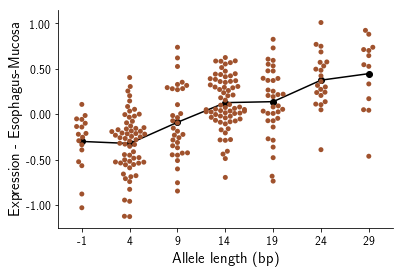

In [23]:
# CWF19L1

chrom = "chr10"
start = 102027668
end = 102027668
gene = "ENSG00000095485.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CWF19L1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 1.6630392190131093e-08 -0.3683043371163413
Thyroid 4.770738324981095e-22 -0.6026085059671374
Skin-NotSunExposed 2.742380692123996e-12 -0.4979096493348098
Brain-Cerebellum 0.00014808500248931605 -0.38744888359894336
Adipose-Subcutaneous 3.9123434334365815e-16 -0.508526796342802
Cells-Transformedfibroblasts 0.00039021646297640437 -0.2580703438653092
Nerve-Tibial 7.619681045633793e-20 -0.5657682404166371
Heart-LeftVentricle 2.464802006114839e-13 -0.5370350241958688
Esophagus-Muscularis 3.18152944024937e-16 -0.5716748558449486
Lung 2.1863385759378703e-14 -0.4940849260082125
Adipose-Visceral 9.206629973127988e-09 -0.4311004297957562
Artery-Aorta 4.658553613252582e-13 -0.5544247571983506
Muscle-Skeletal 4.2754636738507536e-07 -0.2951478591507578
Skin-SunExposed 8.177263091658315e-15 -0.4649670452040126
Brain-Caudate 1.4098281068581042e-08 -0.5546408674428437


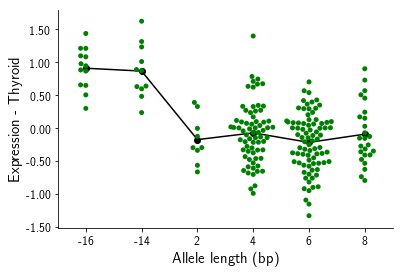

In [24]:
# TIPIN

chrom = "chr15"
start = 66606190
end = 66606190
gene = "ENSG00000075131.5"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_TIPIN.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Mucosa 0.0018215788211227051 -0.1990333545574556
Skin-NotSunExposed 8.6299594471598e-05 -0.2760322896340808
Adipose-Subcutaneous 0.0001482792723811416 -0.23360354414931744
Nerve-Tibial 0.00018060277948445602 -0.2351581015371944
Adipose-Visceral 0.009228613493163538 -0.1940978800190548


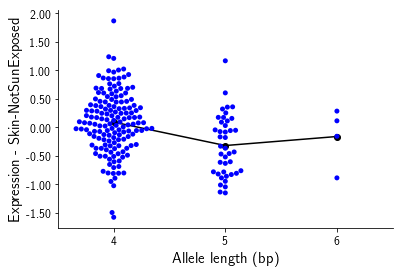

In [25]:
# ITPKC

chrom = "chr19"
start = 41240517
end = 41240517
gene = "ENSG00000086544.2"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ITPKC.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 3.2071151494667065e-07 0.3363950380002303
Skin-NotSunExposed 3.7220625033714104e-08 0.40671345328595376
Brain-Cerebellum 2.0320281386423165e-06 0.4767436798044934
Adipose-Subcutaneous 2.232013432690741e-05 0.28419480457366364
WholeBlood 0.00010837498425778289 0.23008340108608585
Nerve-Tibial 2.071514924270406e-09 0.3934317315494173
Esophagus-Muscularis 0.0005887362708177043 0.2587042149513234
Lung 8.421553595321033e-06 0.2939723750523733
Adipose-Visceral 0.0007461799173874427 0.26553969972383323
Muscle-Skeletal 0.0028024229308166513 0.17734450873153368
Skin-SunExposed 1.1262371229503608e-13 0.450121936039239


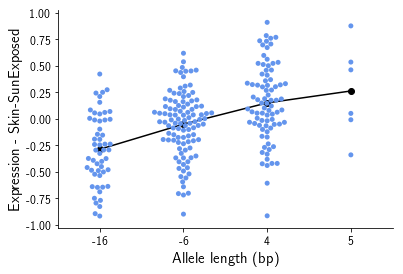

In [26]:
# NUCKS1

chrom = "chr1"
start = 205687349
end = 205687349
gene = "ENSG00000069275.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_NUCKS1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Mucosa 0.00010850051058566376 0.24048487551744266
WholeBlood 0.0010618173827851114 -0.17861977541805066
Muscle-Skeletal 6.607161059420428e-05 0.21403301761879592
Skin-SunExposed 2.682958963511093e-07 0.29316354611839196
Brain-Caudate 0.008880406966083004 0.2506682203715144


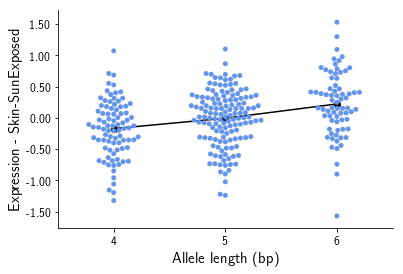

In [27]:
# UBE2Z

chrom = "chr17"
start = 47014824
end = 47014824
gene = "ENSG00000159202.13"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_UBE2Z.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Muscle-Skeletal 3.915828903245052e-06 0.2663660067895053


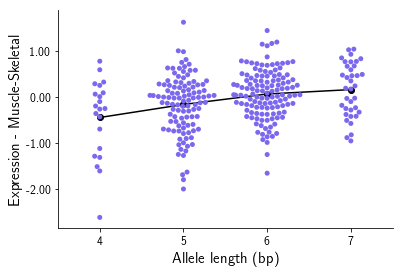

In [28]:
# DERL3

chrom = "chr22"
start = 24149783
end = 24149783
gene = "ENSG00000099958.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_DERL3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 5.1749220781806225e-18 0.5293702523536926
Thyroid 9.604268030319804e-13 0.4531892375394839
Esophagus-Mucosa 1.7323238642718932e-06 0.3223182564847369
Skin-NotSunExposed 7.343903691917634e-19 0.590445232163716
Brain-Cerebellum 0.002101654321705489 0.3117609212230216
Adipose-Subcutaneous 2.024425589727683e-21 0.5653706461356719
Cells-Transformedfibroblasts 7.543257596451609e-07 0.3560636180378049
WholeBlood 0.004607692304877729 0.16826057418233095
Nerve-Tibial 6.406735463933562e-14 0.4707404595725464
Heart-LeftVentricle 0.0022605568640975448 0.2333778546660243
Esophagus-Muscularis 1.0783170438520412e-10 0.4680805678529904
Lung 2.458248353148925e-12 0.4494394638084233
Adipose-Visceral 3.619917679489e-07 0.3763369914880433
Artery-Aorta 2.267738124540951e-11 0.491811955892531
Muscle-Skeletal 4.771964888257859e-11 0.37378951279695466
Skin-SunExposed 8.79221484058377e-15 0.4612000002543345
Brain-Caudate 0.00010764296501359948 0.3927734217363324


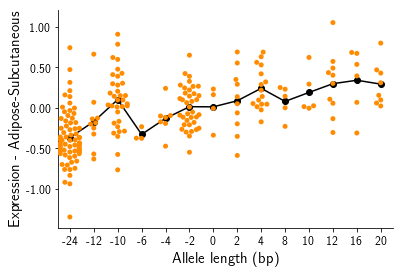

In [29]:
# ANAPC4

chrom = "chr4"
start = 25424376
end = 25424376
gene = "ENSG00000053900.6"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ANAPC4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 0.0004322411873285738 0.2589259527405978
Cells-Transformedfibroblasts 0.008011244357453604 0.18747804212281616
Skin-SunExposed 0.0008820569733109974 0.20236741443052972


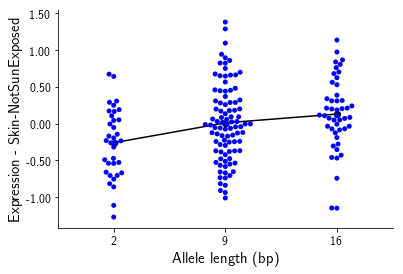

In [30]:
# ADAMTS3

chrom = "chr4"
start = 73506266
end = 73506266
gene = "ENSG00000156140.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ADAMTS3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 2.6624468616535107e-11 0.3891100419350036
Thyroid 0.00029875811966801095 0.22211154971996167
Esophagus-Mucosa 1.8051699456371888e-17 0.4999736136386833
Brain-Cerebellum 1.0295615094042015e-06 0.4518935855058896
Adipose-Subcutaneous 0.001456588066880583 0.19350803584804555
Cells-Transformedfibroblasts 1.3087315496618805e-08 0.3692282385509391
WholeBlood 1.980037167288356e-10 0.3395472279774667
Nerve-Tibial 2.596299151808241e-06 0.2851582547896518
Heart-LeftVentricle 1.270347902147006e-08 0.3915820763476962
Esophagus-Muscularis 1.2713658162500724e-07 0.3539518577956973
Lung 6.663716173129932e-10 0.3729496497217258
Adipose-Visceral 0.000759363297450656 0.2416081206358469
Artery-Aorta 4.768875306078135e-13 0.4944874127366178
Muscle-Skeletal 8.162186727535684e-12 0.3585796973325112


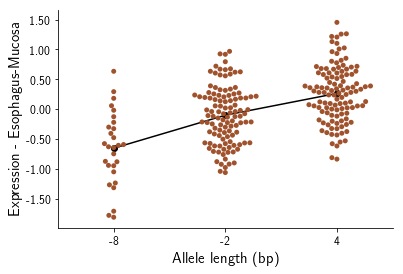

In [31]:
# CRAT

chrom = "chr9"
start = 131872848
end = 131872848
gene = "ENSG00000095321.12"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_CRAT.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 0.00031718904631992327 0.23437148799914045
Cells-Transformedfibroblasts 2.610386961036806e-05 0.2905382882943093
WholeBlood 0.008861382684737901 0.150876989083355
Heart-LeftVentricle 0.0021643864217181148 0.2303456711297225
Lung 0.008846209867881304 0.17007315911716442


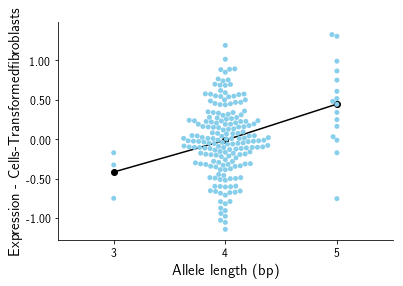

In [32]:
# FOXRED2

chrom = "chr22"
start = 36811155
end = 36811155
gene = "ENSG00000100350.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FOXRED2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 0.006420686803489787 0.16735160774180552
Esophagus-Mucosa 2.1221970414212022e-05 0.2664289502264893
Skin-NotSunExposed 2.4886819059275683e-05 0.2962380840144904
Skin-SunExposed 0.0021310283537045926 0.181534280171833


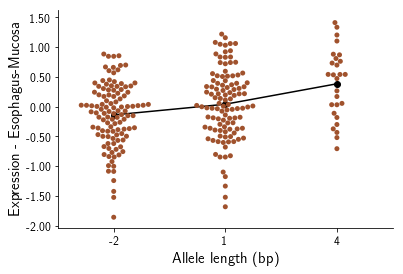

In [33]:
# SLCO1C1

chrom = "chr12"
start = 20856340
end = 20856340
gene = "ENSG00000139155.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SLCO1C1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Adipose-Subcutaneous 0.005926329357909651 0.1729011242761086
WholeBlood 0.0031159634941555297 -0.1660574100022841
Nerve-Tibial 6.133121315866983e-11 0.3976642813223547
Muscle-Skeletal 0.0011186019502963337 0.18081327719297924
Brain-Caudate 5.2700501653487636e-09 0.5454777190636171


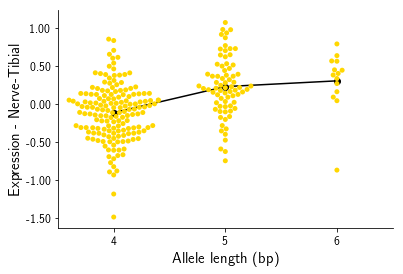

In [34]:
# ZCWPW1

chrom = "chr7"
start = 100078455
end = 100078455
gene = "ENSG00000078487.13"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_ZCWPW1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 2.862520160665028e-06 0.30819084100431543
Adipose-Subcutaneous 0.00022062703249114634 0.2433754047106368
Cells-Transformedfibroblasts 0.004287229386517192 0.20852642016973688
Nerve-Tibial 0.0041532942124443036 0.1925299787304016
Esophagus-Muscularis 0.0005094542043867816 0.2586255586633997
Muscle-Skeletal 2.2705693689352664e-05 0.24852922196471106
Skin-SunExposed 0.00021765455986754497 0.23274065140772146


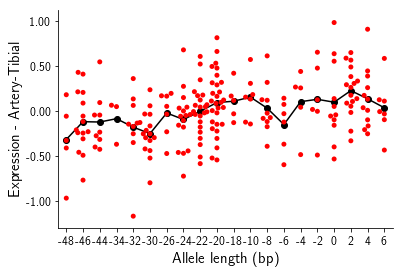

In [35]:
# LUZP1

chrom = "chr1"
start = 23469180
end = 23469180
gene = "ENSG00000169641.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_LUZP1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 0.000870056793493641 0.2113854841464657
Thyroid 0.00023807042173103847 0.23558152012477626
Adipose-Subcutaneous 0.0011870739922965493 0.20553587106163887
WholeBlood 0.0014315681633846158 0.18207560398790096
Lung 0.0001914050166144192 0.2400136788674539
Muscle-Skeletal 0.006897450939005366 0.1521867212899091


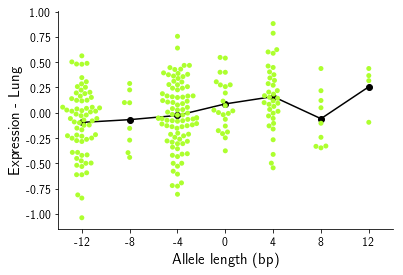

In [36]:
# PSMB3

chrom = "chr17"
start = 36944431
end = 36944431
gene = "ENSG00000108294.4"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PSMB3.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Esophagus-Mucosa 0.0004178845130192389 -0.22237297852211685


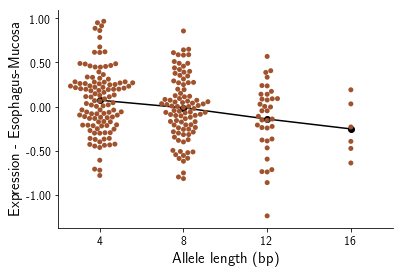

In [37]:
# AAGAB

chrom = "chr15"
start = 67443661
end = 67443661
gene = "ENSG00000103591.8"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_AAGAB.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Thyroid 0.0007998973751073863 0.20907671603577266
Esophagus-Mucosa 0.0004220734509325838 0.22309841774442007
Skin-NotSunExposed 1.5425820168282582e-05 0.29971765087852104
Nerve-Tibial 6.6155913057657575e-06 0.27637162520192265
Esophagus-Muscularis 0.002871510488655382 0.2062224264712333
Skin-SunExposed 0.008160294917919695 0.15614689514044727
Brain-Caudate 0.00048601093065294093 0.3345674790837005


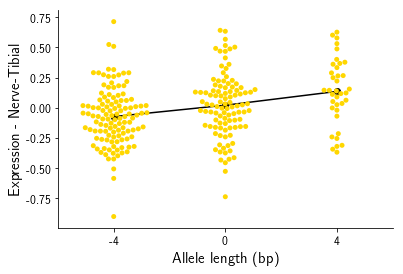

In [38]:
# SF3B1

chrom = "chr2"
start = 198331983
end = 198331983
gene = "ENSG00000115524.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_SF3B1.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 0.00013329349902912863 0.24216255263589384
Adipose-Subcutaneous 0.0007612741239519441 0.2124018841649908
Nerve-Tibial 0.006573310864010896 0.17498617953070056


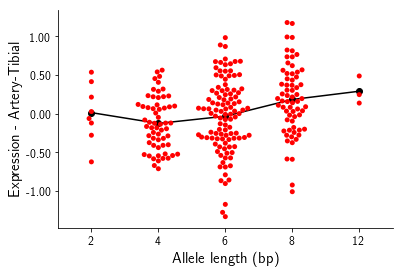

In [39]:
# IK

chrom = "chr5"
start = 140137981
end = 140137981
gene = "ENSG00000113141.11"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_IK.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 1.395875924367521e-20 -0.5341477165537689
Thyroid 6.901620880734192e-17 -0.4997969340540078
Esophagus-Mucosa 7.390556694274526e-40 -0.7193988964471392
Skin-NotSunExposed 2.493989831929639e-19 -0.5842425708094541
Adipose-Subcutaneous 8.03054317563278e-33 -0.6574554863149462
Cells-Transformedfibroblasts 2.7386137559162875e-26 -0.6457877885517134
WholeBlood 1.6980792504544644e-36 -0.6317701889980583
Nerve-Tibial 4.25240986522932e-25 -0.5945585006258376
Heart-LeftVentricle 2.254070531527453e-17 -0.5656081904743545
Esophagus-Muscularis 4.6493554352320476e-17 -0.541026418645324
Lung 5.811232810343305e-29 -0.6321233723554056
Adipose-Visceral 9.896105358074472e-27 -0.6854218913926022
Artery-Aorta 1.867450287045243e-12 -0.4890630242351148
Muscle-Skeletal 1.2998042050704008e-42 -0.6628194994207706
Skin-SunExposed 1.0905223294387671e-33 -0.6384288936566961
Brain-Caudate 0.006694944946219551 -0.273598774790495


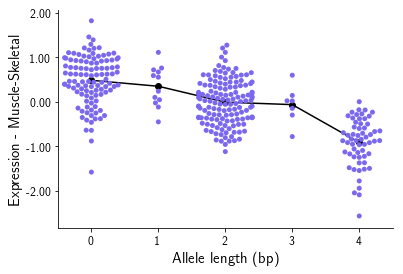

In [3]:
# PEX6

chrom = "chr6"
start = 42921475
end = 42921475
gene = "ENSG00000124587.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_PEX6.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Skin-NotSunExposed 0.0009162823979086448 0.2309433307131489
Adipose-Subcutaneous 3.054563871679257e-07 0.3082855682192825
Nerve-Tibial 7.533629017243251e-07 0.3022265661673146
Heart-LeftVentricle 0.001924164558065745 0.2207888263001295
Esophagus-Muscularis 0.003946586044693543 0.20001012257086034
Lung 2.649007857291252e-08 0.3402716951862586
Adipose-Visceral 5.594349692159454e-07 0.35628837026485666
Muscle-Skeletal 0.004835436249541418 0.15361211256452156
Skin-SunExposed 6.822384775969535e-06 0.26030483324005393


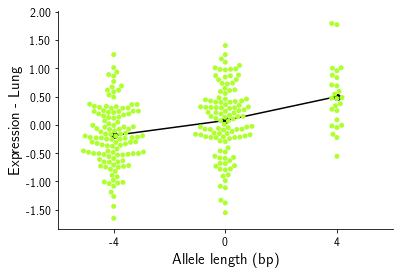

In [4]:
# FCER2

chrom = "chr19"
start = 7765393
end = 7765393
gene = "ENSG00000104921.10"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_FCER2.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)

Artery-Tibial 5.618676913484386e-05 -0.2421677494482726
Skin-NotSunExposed 2.3757179518076897e-05 -0.28987656934461997
Adipose-Subcutaneous 1.3877741475702744e-05 -0.26251043461388124
Nerve-Tibial 5.294444496124001e-05 -0.2479574329979853
Esophagus-Muscularis 0.006538871784630761 -0.18623745689140253
Artery-Aorta 0.004346266498776501 -0.2060316547194378


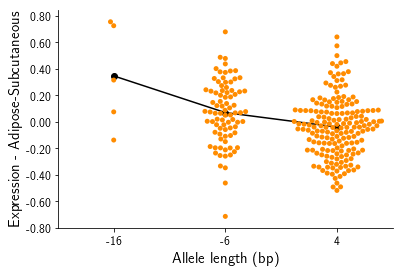

In [5]:
# MRPL4

chrom = "chr19"
start = 10338986
end = 10338986
gene = "ENSG00000105364.9"
best_tissue, best_p, best_beta = GetBestTissue(chrom, start, gene, data)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_Literature_MRPL4.pdf")
else: fname = None
PlotESTR(gene, best_tissue, chrom, start, end, COLORS, fname=fname)